### Este é um projeto para a matéria "**Algoritmos de Inteligência Artificial para classificação**" da Infnet.
### Feito 100% por **Everton Vanoni Fernandes** com o conhecimento adquirido nas aulas ao vivo, no curso de Kaggle, e pesquisas no google em expecificos pontos.

In [ ]:
# Importações que vamos usar neste arquivo.
from kagglehub import KaggleDatasetAdapter, load_dataset
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.impute import SimpleImputer

### 1. Carregamento do data set

Para facilitar, e não precisar do arquivo de dataset baixado no mesmo local deste arquivo, ou usar o drive que necessita de um login, vamos usar o kagglehub.

<ipython-input-34-10b097a2f089>:3: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = load_dataset(KaggleDatasetAdapter.PANDAS, "rajyellow46/wine-quality", file_path)


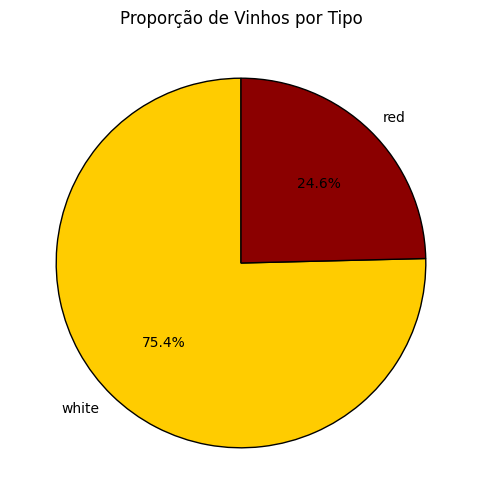

In [ ]:
file_path = "winequalityN.csv"

df = load_dataset(KaggleDatasetAdapter.PANDAS, "rajyellow46/wine-quality", file_path)

# Cria um gráfico pizza apenas para visualizar o resultado. E mostrar a porcentagem de cada tipo de vinho.
wine_counts = df['type'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(
    wine_counts,
    labels=wine_counts.index,  # Usa os próprios tipos de vinho como rótulos
    autopct='%1.1f%%',
    colors=['#ffcc00', '#8b0000'],  # Define cores para vinhos brancos e tintos
    startangle=90,
    wedgeprops={'edgecolor': 'black'}
)
plt.title("Proporção de Vinhos por Tipo")
plt.show()

### 2. Filtrar apenas por vinhos do tipo "branco"

Este dataset contem 75.4% de vinhos brancos, e ~24.6% de vinhos vermelhos, mas só estamos interessados nos vinhos do tipo branco, então vamos filtrar na celula abaixo.

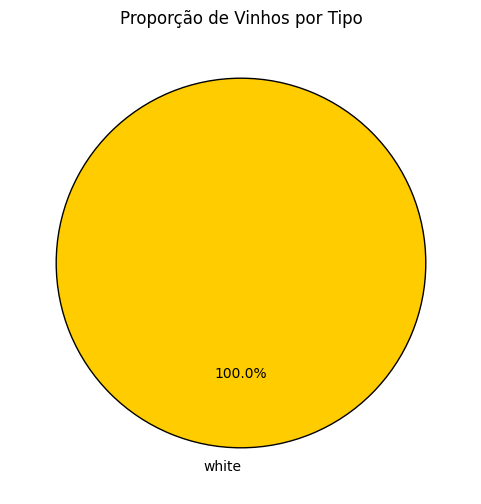

In [ ]:
df_white_wine = df[df['type'] == 'white']


# Cria um gráfico pizza apenas para visualizar o resultado do filtro.
white_wine_counts = df_white_wine['type'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(
    white_wine_counts,
    labels=white_wine_counts.index,  # Usa os próprios tipos de vinho como rótulos
    autopct='%1.1f%%',
    colors=['#ffcc00', '#8b0000'],  # Define cores para vinhos brancos e tintos
    startangle=90,
    wedgeprops={'edgecolor': 'black'}
)
plt.title("Proporção de Vinhos por Tipo")
plt.show()

### 3. Adicionando a variavel "opinion"

Temos o seguinte requisito para este projeto:

> criar variavel “opinion” onde o valor deve ser 0 caso o “quality” seja menor ou igual a 5, se nao deve ser 1

Visto isso, vamos adicionar essa uma nova coluna ao dataset, onde:
- Se a qualidade do vinho (quality) for menor ou igual a 5, opinion será 0 (ruim).
- Se a qualidade for maior que 5, opinion será 1 (bom).

In [ ]:
df_white_wine['opinion'] = (df_white_wine['quality'] >= 5).astype(int)

<ipython-input-36-f4ef4c3bd8e1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_white_wine['opinion'] = (df_white_wine['quality'] >= 5).astype(int)


### 4. Analisando as variáveis presentes na base

Temos o seguinte requisito para o projeto:

> Descreva as variáveis presentes na base. Quais são as variáveis? Quais são os tipos de variáveis (discreta, categórica, contínua)? Quais são as médias e desvios padrões?

Vou estar respondendo cada pergunta junto com um "print" na celula abaixo.


In [ ]:
# Quais são as variáveis?
# Como podemos ver no print abaixo, as variáveis sao:
# - type: Tipo do vinho
# - fixed acidity: Acidez fixa
# - volatile acidity: Acidez volátil
# - citric acid: Ácido cítrico
# - residual sugar: Açúcar residual
# - chlorides: Cloretos
# - free sulfur dioxide: Dióxido de enxofre livre
# - total sulfur dioxide: Dióxido de enxofre total
# - density: Densidade
# - pH: pH do vinho
# - sulphates: Sulfatos
# - alcohol: Teor alcoólico
# - quality: Qualidade do vinho (nota de 0 a 10)
# - opinion: Variável criada para classificação (0 = ruim, 1 = bom)
print("Colunas do dataset:", df_white_wine.columns.tolist())

# Quais são os tipos de variáveis (discreta, categórica, continuas)?
# categórica:
# - type: Representa o tipo de vinho (red ou white), ou seja, e categorica
# - opinion: Criamos essa coluna nova para classificarmos se tem qualidade ou nao, ou seja, e categorica tambem
# discreta:
# - quality: Representa notas de 0 a 10, sempre numeros inteiros e contaveis
# continuas:
# Todas as outras variaveis, sao numeros quebrados, ou podemos dizer decimais, do tipo float
print("\nTipos das variáveis:\n", df_white_wine.dtypes)

# Quais são as médias e desvios padrões?
# Podemos estar verificando as respostas para essa pergunta no print abaixo,
# para verificar as médias podemos estar olhando para a variavel "mean", e
# para verificar o desvio padrao olhamos para a variavel "std".
print("\nEstatísticas das variáveis numéricas:\n", df_white_wine.describe())

Colunas do dataset: ['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'opinion']

Tipos das variáveis:
 type                     object
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
opinion                   int64
dtype: object

Estatísticas das variáveis numéricas:
        fixed acidity  volatile acidity  citric acid  residual sugar  \
count    4890.000000       4891.000000  4896.000000     4896.000000   
mean        6.855532          0.278252     0.334250        6.393250   
std         0.843808          0.100811  

### 5. Etapas necessárias para criar um modelo de classificação eficiente

#### Antes de começar a modelagem, é essencial entender:

- O objetivo do modelo: prever se um vinho tem boa qualidade (opinion = 1) ou não (opinion = 0)
- O significado das variáveis e sua relação com a variável alvo (opinion)
- Possíveis desafios como desbalanceamento de classes, outliers e correlação entre variáveis

#### Pré-processamento dos Dados

1. Tratamento de valores faltantes

Precisamos fazer o tratamento de valores faltantes, para casos onde o valor e null, caso tenha valores null, precisamos remover, ou preencher com a media, mediana ou outro metodo.

2. Tratamento de Outliers

Precisamos identificar valores extremos nas variaveis continuas usando graficos como boxplots, e para resolver podemos fazer a remocao dos outliers ou a normalizacao dos dados.

#### Divisao entre conjunto de treino e teste

O dataset deve ser dividido em treino, e teste para avaliar o desempenho do modelo.

#### Escolha do modelo

Com os dados preparados, podemos testar diferentes algoritmos de classificacao.
Para este projeto iremos estar testando com os mesmos dados, os seguintes modelos:

- Regressão Logística
- Árvores de Decisão
- SVM (Support Vector Machine)

#### Avaliação do Modelo

Apos treinar o modelo, precisamos avaliar sua performance das seguintes formas:

1. Usar "confusion_matrix" para saber a Matriz de Confusao
2. Usar "accuracy_score" para saber a Acurácia
3. Usar "classification_report" para outras metricas importantes como precisao, recall e f1-score

#### Ajuste de Hiperparâmetros

Se os resultados nao forem satisfatorios, podemos ajustar os params do modelo usando tecnicas como:

- Grid Search: Testa combinacoes de parametros para encontrar os melhores valores.
- Random Search - Testa valores aleatorios e pode ser mais rapido.


#### Implementação e Otimização:

Se o modelo estiver satisfatorio, podemos aplicar o modelo em um pipeline para facilitar o uso em producao, e apos isso so salvar o modelo de alguma forma, como por exemplo usando o "joblib.dump(model, "wine_model.pk1")".





### 6. Preparação das variaveis


In [ ]:
# separarando em x e y
target = 'opinion'
x = df_white_wine.drop([target, 'quality'], axis=1)
y = df_white_wine[[target]]

In [ ]:
# separando variáveis numéricas e categóricas
cat = ['type']
num = [col for col in x.columns if col not in cat]

In [ ]:
# separando treino e teste - com estratificação
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y)

### 7. Criação dos modelos

Vamos comecar a colocar a mão na massa criando os modelos, que vai ser o de regressão logística, arvore de decisão e SVM usando um modelo de validação cruzada estratificada com k-folds (k=10) para realizar a classificação de cada um.

#### Requisitos para cada modelo:

Precisamos calcular para a base de teste:

- [x]  i. a média e desvio da acurácia dos modelos obtidos;
- [x]  ii. a média e desvio da precisão dos modelos obtidos;
- [x]  iii. a média e desvio da recall dos modelos obtidos;
- [x]  iv. a média e desvio do f1-score dos modelos obtidos.




In [ ]:
# criando um pipe de processamento
preprocessor = ColumnTransformer([
    ('category', OneHotEncoder(drop='first', handle_unknown='ignore'), cat),
    ('numeric', RobustScaler(), num)
])

In [ ]:
# criando os pipes para cada modelo
logistic_regression_pipe = Pipeline([
    ('transformer', preprocessor),
    ('imputer', SimpleImputer(strategy='mean')), # Trata valorer NaN
    ('selector', SelectKBest(f_classif)),
    ('model', LogisticRegression(solver='saga'))
])

decision_tree_pipe = Pipeline([
    ('transformer', preprocessor),
    ('imputer', SimpleImputer(strategy='mean')), # Trata valorer NaN
    ('selector', SelectKBest(f_classif)),
    ('model', DecisionTreeClassifier(random_state=5))
])

svc_pipe = Pipeline([
    ('transformer', preprocessor),
    ('imputer', SimpleImputer(strategy='mean')), # Trata valorer NaN
    ('selector', SelectKBest(f_classif)),
    ('svc', SVC(random_state=2, probability=True))
])

In [ ]:
# configurando o espaço de busca
params_grid_logistic_regression = {
    'model__penalty': ['l1', 'l2', 'elasticnet'],
    'model__C': [0.001, 0.01, 0.1, 1, 10],
    'model__l1_ratio': [0.25, 0.5, 0.75],
    'model__class_weight': ['balanced', None],
    'selector__k': range(1, 11)
}

params_grid_decision_three = {
    'model__max_depth': range(2, 11),
    'model__criterion': ['gini', 'entropy'],
    'model__class_weight': ['balanced', None],
    'selector__k': range(1, 11)
}

params_grid_svc = {
    'selector__k': range(1, 11)
}

In [ ]:
# configuranco o amostrador - estratificado
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=5)

In [ ]:
# configura um buscador aleatório - logistic regression
random_search_logistic_regression = RandomizedSearchCV(
    estimator=logistic_regression_pipe,
    param_distributions=params_grid_logistic_regression,
    n_iter=50,
    scoring='f1',
    cv=splitter,
    refit=True,
    error_score=0,
    verbose=10
)

# configura um buscador aleatório - decision three
random_search_decision_three = RandomizedSearchCV(
    estimator=decision_tree_pipe,
    param_distributions=params_grid_decision_three,
    n_iter=50,
    scoring='f1',
    cv=splitter,
    refit=True,
    error_score=0,
    verbose=10
)

# configura um buscador aleatório - svm
random_search_svm = RandomizedSearchCV(
    estimator=svc_pipe,
    param_distributions=params_grid_svc,
    n_iter=50,
    scoring='f1',
    cv=splitter,
    refit=True,
    error_score=0,
    verbose=10
)

In [ ]:
# busca os melhores params para logistic regression
random_search_logistic_regression.fit(x_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV 1/10; 1/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=4
[CV 1/10; 1/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=4;, score=0.835 total time=   0.0s
[CV 2/10; 1/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=4
[CV 2/10; 1/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=4;, score=0.839 total time=   0.0s
[CV 3/10; 1/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=4
[CV 3/10; 1/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=4;, score=0.845 total time=   0.0s
[CV 4/10; 1/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 7/10; 1/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=4;, score=0.854 total time=   0.0s
[CV 8/10; 1/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=4
[CV 8/10; 1/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=4;, score=0.846 total time=   0.0s
[CV 9/10; 1/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=4
[CV 9/10; 1/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=4;, score=0.839 total time=   0.0s
[CV 10/10; 1/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=4
[CV 10/10; 1/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=4;, score=0.837 total time=   0.0s
[CV 1/10; 2/50] START model

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 4/10; 2/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=3;, score=0.981 total time=   0.0s
[CV 5/10; 2/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=3
[CV 5/10; 2/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=3;, score=0.981 total time=   0.0s
[CV 6/10; 2/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=3
[CV 6/10; 2/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=3;, score=0.981 total time=   0.0s
[CV 7/10; 2/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=3
[CV 7/10; 2/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l2, selector__k=3;, score=0.981 total time=   0.0s
[CV 8/10; 2/50] START model__C=0.01, model__class_weight=

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 1/10; 3/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=10;, score=0.857 total time=   0.1s
[CV 2/10; 3/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=10
[CV 2/10; 3/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=10;, score=0.847 total time=   0.1s
[CV 3/10; 3/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=10
[CV 3/10; 3/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=10;, score=0.861 total time=   0.1s
[CV 4/10; 3/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=10


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 4/10; 3/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=10;, score=0.850 total time=   0.1s
[CV 5/10; 3/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=10
[CV 5/10; 3/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=10;, score=0.844 total time=   0.1s
[CV 6/10; 3/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=10
[CV 6/10; 3/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=10;, score=0.850 total time=   0.1s
[CV 7/10; 3/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=10


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 7/10; 3/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=10;, score=0.854 total time=   0.1s
[CV 8/10; 3/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=10
[CV 8/10; 3/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=10;, score=0.844 total time=   0.1s
[CV 9/10; 3/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=10
[CV 9/10; 3/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=10;, score=0.853 total time=   0.1s
[CV 10/10; 3/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=10


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packa

[CV 10/10; 3/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=10;, score=0.872 total time=   0.1s
[CV 1/10; 4/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10
[CV 1/10; 4/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10;, score=0.863 total time=   0.0s
[CV 2/10; 4/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10
[CV 2/10; 4/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10;, score=0.855 total time=   0.0s
[CV 3/10; 4/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10
[CV 3/10; 4/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=10;, scor

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 4/10; 5/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=3;, score=0.981 total time=   0.0s
[CV 5/10; 5/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=3
[CV 5/10; 5/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=3;, score=0.981 total time=   0.0s
[CV 6/10; 5/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=3
[CV 6/10; 5/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=3;, score=0.981 total time=   0.0s
[CV 7/10; 5/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=3
[CV 7/10; 5/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=3;, score=0.979 total time=   0.0s
[CV 8/10

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 1/10; 6/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=6;, score=0.851 total time=   0.1s
[CV 2/10; 6/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=6
[CV 2/10; 6/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=6;, score=0.846 total time=   0.1s
[CV 3/10; 6/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=6
[CV 3/10; 6/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=6;, score=0.852 total time=   0.0s
[CV 4/10; 6/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=6
[CV 4/10; 6/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=6;, score=0.846 total time=   0.1s
[CV 5/10; 6/50] START model__C=10, m

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 1/10; 7/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5;, score=0.859 total time=   0.0s
[CV 2/10; 7/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5
[CV 2/10; 7/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5;, score=0.865 total time=   0.0s
[CV 3/10; 7/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5
[CV 3/10; 7/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5;, score=0.861 total time=   0.0s
[CV 4/10; 7/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5
[CV 4/10; 7/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5;, score=0.881 total time=   0.0s
[CV 5/10; 7/50] START 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 9/10; 7/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5;, score=0.860 total time=   0.0s
[CV 10/10; 7/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5
[CV 10/10; 7/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5;, score=0.875 total time=   0.0s
[CV 1/10; 8/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=2
[CV 1/10; 8/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=2;, score=0.000 total time=   0.0s
[CV 2/10; 8/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=2
[CV 2/10; 8/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=2;, score=0.000 total time=   0.0s
[CV 3/10; 8/50] STAR

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 8/10; 8/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=2;, score=0.981 total time=   0.0s
[CV 9/10; 8/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=2
[CV 9/10; 8/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=2;, score=0.982 total time=   0.0s
[CV 10/10; 8/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=2
[CV 10/10; 8/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=2;, score=0.000 total time=   0.0s
[CV 1/10; 9/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=2
[CV 1/10; 9/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=2;, score=0.831 total time=   0.0s
[CV 2/10; 9/50] START mo

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 6/10; 9/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=2;, score=0.844 total time=   0.0s
[CV 7/10; 9/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=2
[CV 7/10; 9/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=2;, score=0.856 total time=   0.0s
[CV 8/10; 9/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=2
[CV 8/10; 9/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=2;, score=0.832 total time=   0.0s
[CV 9/10; 9/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=2
[CV 9/10; 9/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=2;, score=0.846 total time=   0.0s
[CV 10/10; 9/50] START model__C=10, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 3/10; 10/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=10;, score=0.981 total time=   0.0s
[CV 4/10; 10/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=10
[CV 4/10; 10/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=10;, score=0.981 total time=   0.0s
[CV 5/10; 10/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=10
[CV 5/10; 10/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=10;, score=0.981 total time=   0.0s
[CV 6/10; 10/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=10
[CV 6/10; 10/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=10;, score=0.981

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 8/10; 10/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=10;, score=0.981 total time=   0.0s
[CV 9/10; 10/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=10
[CV 9/10; 10/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=10;, score=0.982 total time=   0.0s
[CV 10/10; 10/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=10
[CV 10/10; 10/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=10;, score=0.982 total time=   0.0s
[CV 1/10; 11/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=7
[CV 1/10; 11/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=7;, score=0.981 total

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 3/10; 11/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=7;, score=0.982 total time=   0.1s
[CV 4/10; 11/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=7
[CV 4/10; 11/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=7;, score=0.982 total time=   0.1s
[CV 5/10; 11/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=7
[CV 5/10; 11/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=7;, score=0.981 total time=   0.1s
[CV 6/10; 11/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=7
[CV 6/10; 11/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=7;, score=0.981 total time=   0.1s
[CV 7/10

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 11/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=7;, score=0.979 total time=   0.1s
[CV 8/10; 11/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=7
[CV 8/10; 11/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=7;, score=0.981 total time=   0.1s
[CV 9/10; 11/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=7
[CV 9/10; 11/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=7;, score=0.982 total time=   0.1s
[CV 10/10; 11/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=7
[CV 10/10; 11/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=elasticnet, selector__k=7;, score=0.981 total time=   0.1s
[CV 1/

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

[CV 1/10; 12/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=2;, score=0.831 total time=   0.0s
[CV 2/10; 12/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=2
[CV 2/10; 12/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=2;, score=0.852 total time=   0.0s
[CV 3/10; 12/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=2
[CV 3/10; 12/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=2;, score=0.818 total time=   0.0s
[CV 4/10; 12/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=2
[CV 4/10; 12/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=2;, score=0.878 total time=   0.0s
[CV 5/10; 12/50] START model_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 8/10; 12/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=2;, score=0.832 total time=   0.0s
[CV 9/10; 12/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=2
[CV 9/10; 12/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=2;, score=0.846 total time=   0.0s
[CV 10/10; 12/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=2
[CV 10/10; 12/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l1, selector__k=2;, score=0.831 total time=   0.0s
[CV 1/10; 13/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6
[CV 1/10; 13/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=0.981 total time=   0.0s
[CV 2/10; 13/50] START 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 4/10; 13/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=0.982 total time=   0.1s
[CV 5/10; 13/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6
[CV 5/10; 13/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=0.981 total time=   0.1s
[CV 6/10; 13/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6
[CV 6/10; 13/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=0.981 total time=   0.0s
[CV 7/10; 13/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6
[CV 7/10; 13/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=0.979 total time=   0.0s
[CV 8/10; 13/50

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 8/10; 13/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=0.981 total time=   0.1s
[CV 9/10; 13/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6
[CV 9/10; 13/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=0.982 total time=   0.1s
[CV 10/10; 13/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6
[CV 10/10; 13/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=0.982 total time=   0.0s
[CV 1/10; 14/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5
[CV 1/10; 14/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=0.981 total time=   0.0s
[CV 2/10; 14/50] START model_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 4/10; 14/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=0.982 total time=   0.0s
[CV 5/10; 14/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5
[CV 5/10; 14/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=0.981 total time=   0.0s
[CV 6/10; 14/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5
[CV 6/10; 14/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=0.981 total time=   0.0s
[CV 7/10; 14/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5
[CV 7/10; 14/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=0.979 total time=   0.0s
[CV 8/10; 14/50] START model__C=1, model__class_weight=None, model__l1_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 10/10; 14/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=5;, score=0.982 total time=   0.0s
[CV 1/10; 15/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=9
[CV 1/10; 15/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=9;, score=0.859 total time=   0.1s
[CV 2/10; 15/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=9
[CV 2/10; 15/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=9;, score=0.848 total time=   0.1s
[CV 3/10; 15/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=9
[CV 3/10; 15/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=9;, score=0.856 total time=   0.1s
[CV 4/10; 15/50] START model

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 4/10; 15/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=9;, score=0.862 total time=   0.1s
[CV 5/10; 15/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=9
[CV 5/10; 15/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=9;, score=0.841 total time=   0.1s
[CV 6/10; 15/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=9
[CV 6/10; 15/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=9;, score=0.852 total time=   0.1s
[CV 7/10; 15/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=9
[CV 7/10; 15/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=9;, score=0.856 total time=   0.1s
[CV 8/10; 15/50] START

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 8/10; 15/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=9;, score=0.838 total time=   0.1s
[CV 9/10; 15/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=9
[CV 9/10; 15/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=9;, score=0.855 total time=   0.1s
[CV 10/10; 15/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=9
[CV 10/10; 15/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=9;, score=0.864 total time=   0.1s
[CV 1/10; 16/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8
[CV 1/10; 16/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=0.981 total time=   0.1s
[CV 2/10; 16/50] START model__C=

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 2/10; 16/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=0.981 total time=   0.1s
[CV 3/10; 16/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8
[CV 3/10; 16/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=0.982 total time=   0.1s
[CV 4/10; 16/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8
[CV 4/10; 16/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=0.982 total time=   0.1s
[CV 5/10; 16/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 5/10; 16/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=0.981 total time=   0.1s
[CV 6/10; 16/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8
[CV 6/10; 16/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=0.981 total time=   0.1s
[CV 7/10; 16/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8
[CV 7/10; 16/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=0.979 total time=   0.1s
[CV 8/10; 16/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 8/10; 16/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=0.981 total time=   0.1s
[CV 9/10; 16/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8
[CV 9/10; 16/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=0.982 total time=   0.1s
[CV 10/10; 16/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8
[CV 10/10; 16/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=0.981 total time=   0.1s
[CV 1/10; 17/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=1
[CV 1/10; 17/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=1;, score=0.981 total time=   0.0s
[CV 2/10; 17/50] START model__C=1, model__class_weight=None, m

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

[CV 3/10; 17/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=1;, score=0.982 total time=   0.0s
[CV 4/10; 17/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=1
[CV 4/10; 17/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=1;, score=0.981 total time=   0.0s
[CV 5/10; 17/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=1
[CV 5/10; 17/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=1;, score=0.981 total time=   0.0s
[CV 6/10; 17/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=1
[CV 6/10; 17/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=1;, score=0.981 total time=   0.0s
[CV 7/10; 17/50] START model__C=1, model__class_weight=None, mod

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 2/10; 18/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2;, score=0.852 total time=   0.0s
[CV 3/10; 18/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2
[CV 3/10; 18/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2;, score=0.818 total time=   0.0s
[CV 4/10; 18/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2
[CV 4/10; 18/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2;, score=0.878 total time=   0.0s
[CV 5/10; 18/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2
[CV 5/10; 18/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2;, score=0.830

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 10/10; 18/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=2;, score=0.831 total time=   0.0s
[CV 1/10; 19/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8
[CV 1/10; 19/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=0.849 total time=   0.1s
[CV 2/10; 19/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8
[CV 2/10; 19/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=0.848 total time=   0.1s
[CV 3/10; 19/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

[CV 3/10; 19/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=0.859 total time=   0.1s
[CV 4/10; 19/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8
[CV 4/10; 19/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=0.858 total time=   0.1s
[CV 5/10; 19/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8
[CV 5/10; 19/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=0.838 total time=   0.1s
[CV 6/10; 19/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

[CV 6/10; 19/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=0.856 total time=   0.1s
[CV 7/10; 19/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8
[CV 7/10; 19/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=0.854 total time=   0.1s
[CV 8/10; 19/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8
[CV 8/10; 19/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=0.838 total time=   0.1s
[CV 9/10; 19/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

[CV 9/10; 19/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=0.855 total time=   0.1s
[CV 10/10; 19/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8
[CV 10/10; 19/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=8;, score=0.869 total time=   0.0s
[CV 1/10; 20/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=7
[CV 1/10; 20/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=7;, score=0.981 total time=   0.1s
[CV 2/10; 20/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=7
[CV 2/10; 20/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=7;, score=0.981 total time=   0.0s
[CV 3/10; 20/50] START model__C=0.1,

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 3/10; 20/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=7;, score=0.982 total time=   0.1s
[CV 4/10; 20/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=7
[CV 4/10; 20/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=7;, score=0.981 total time=   0.0s
[CV 5/10; 20/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=7
[CV 5/10; 20/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=7;, score=0.981 total time=   0.1s
[CV 6/10; 20/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=7
[CV 6/10; 20/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=7;, score=0.981 total time=   0.1s
[CV 7/10; 20/50] START model__C=0.1, model__class_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 7/10; 20/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=7;, score=0.979 total time=   0.0s
[CV 8/10; 20/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=7
[CV 8/10; 20/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=7;, score=0.981 total time=   0.0s
[CV 9/10; 20/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=7
[CV 9/10; 20/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=7;, score=0.982 total time=   0.1s
[CV 10/10; 20/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=7
[CV 10/10; 20/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=7;, score=0.981 total time=   0.0s
[CV 1/10; 21/50] START model__C=10, model__class

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 21/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=0.981 total time=   0.1s
[CV 7/10; 21/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6
[CV 7/10; 21/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=0.979 total time=   0.1s
[CV 8/10; 21/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6
[CV 8/10; 21/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=0.981 total time=   0.0s
[CV 9/10; 21/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6
[CV 9/10; 21/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=0.982 total time=   0.0s
[CV 10/1

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 22/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=8;, score=0.872 total time=   0.0s
[CV 2/10; 22/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=8
[CV 2/10; 22/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=8;, score=0.867 total time=   0.0s
[CV 3/10; 22/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=8
[CV 3/10; 22/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=8;, score=0.868 total time=   0.0s
[CV 4/10; 22/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=8
[CV 4/10; 22/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=8;, score=0.885 total time=   0.0s
[CV 5/10

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 6/10; 22/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=8;, score=0.848 total time=   0.0s
[CV 7/10; 22/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=8
[CV 7/10; 22/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=8;, score=0.873 total time=   0.0s
[CV 8/10; 22/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=8
[CV 8/10; 22/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=8;, score=0.851 total time=   0.0s
[CV 9/10; 22/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=8
[CV 9/10; 22/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=8;, score=0.860 total time=   0.0s
[CV 10/1

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 1/10; 23/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=1;, score=0.981 total time=   0.0s
[CV 2/10; 23/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=1
[CV 2/10; 23/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=1;, score=0.981 total time=   0.0s
[CV 3/10; 23/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=1
[CV 3/10; 23/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=1;, score=0.982 total time=   0.0s
[CV 4/10; 23/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=1
[CV 4/10; 23/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=1;, score=0.981 total time=   0.0s
[CV 5/10; 23/50] START model__C=1, model__class_weight=None, mod

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 8/10; 23/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=1;, score=0.981 total time=   0.0s
[CV 9/10; 23/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=1
[CV 9/10; 23/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=1;, score=0.982 total time=   0.0s
[CV 10/10; 23/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=1
[CV 10/10; 23/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=1;, score=0.981 total time=   0.0s
[CV 1/10; 24/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5
[CV 1/10; 24/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5;, score=0.841 total time=   0.0s
[CV 2/10; 24/50] START model__C=1, model__class_weight=b

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 3/10; 24/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5;, score=0.852 total time=   0.1s
[CV 4/10; 24/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5
[CV 4/10; 24/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5;, score=0.846 total time=   0.1s
[CV 5/10; 24/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5
[CV 5/10; 24/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5;, score=0.831 total time=   0.1s
[CV 6/10; 24/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5
[CV 6/10; 24/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5;, score=0.854 total time=   0.0s
[CV 7/10; 24/50] START model__C=1, model__c

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 7/10; 24/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5;, score=0.848 total time=   0.1s
[CV 8/10; 24/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5
[CV 8/10; 24/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5;, score=0.840 total time=   0.0s
[CV 9/10; 24/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5
[CV 9/10; 24/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5;, score=0.860 total time=   0.1s
[CV 10/10; 24/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5
[CV 10/10; 24/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=5;, score=0.864 total time=   0.1s
[CV 1/10; 25/50] START model__C=0.001, mo

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 2/10; 25/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=3;, score=0.981 total time=   0.0s
[CV 3/10; 25/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=3
[CV 3/10; 25/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=3;, score=0.000 total time=   0.0s
[CV 4/10; 25/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=3
[CV 4/10; 25/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=3;, score=0.981 total time=   0.0s
[CV 5/10; 25/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=3
[CV 5/10; 25/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=3;, score=0.981 total time=   0.0s
[CV 6/10; 25/50

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 1/10; 26/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=9;, score=0.981 total time=   0.0s
[CV 2/10; 26/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=9
[CV 2/10; 26/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=9;, score=0.981 total time=   0.0s
[CV 3/10; 26/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=9
[CV 3/10; 26/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=9;, score=0.982 total time=   0.1s
[CV 4/10; 26/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=9
[CV 4/10; 26/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=9;, score=0.981 total time=   0.1s
[CV 5/10; 26/50] START model__C=0.1, model__class_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 5/10; 26/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=9;, score=0.981 total time=   0.0s
[CV 6/10; 26/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=9
[CV 6/10; 26/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=9;, score=0.981 total time=   0.1s
[CV 7/10; 26/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=9
[CV 7/10; 26/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=9;, score=0.981 total time=   0.0s
[CV 8/10; 26/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=9
[CV 8/10; 26/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=9;, score=0.981 total time=   0.1s
[CV 9/10; 26/50] START model__C=0.1, model__class_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 9/10; 26/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=9;, score=0.982 total time=   0.1s
[CV 10/10; 26/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=9
[CV 10/10; 26/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=9;, score=0.982 total time=   0.1s
[CV 1/10; 27/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3
[CV 1/10; 27/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3;, score=0.844 total time=   0.0s
[CV 2/10; 27/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3
[CV 2/10; 27/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3;, score=0.851 total time=   0.0s
[CV 3/10; 27/50] START model

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 6/10; 27/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3;, score=0.832 total time=   0.0s
[CV 7/10; 27/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3
[CV 7/10; 27/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3;, score=0.844 total time=   0.0s
[CV 8/10; 27/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3
[CV 8/10; 27/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3;, score=0.839 total time=   0.0s
[CV 9/10; 27/50] START model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3
[CV 9/10; 27/50] END model__C=0.01, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=3;, score=0.846 total time=   0.0s
[CV 10/10; 27/5

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 4/10; 28/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=1;, score=0.981 total time=   0.0s
[CV 5/10; 28/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=1
[CV 5/10; 28/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=1;, score=0.981 total time=   0.0s
[CV 6/10; 28/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=1
[CV 6/10; 28/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=1;, score=0.981 total time=   0.0s
[CV 7/10; 28/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=1
[CV 7/10; 28/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=1;, score=0.981 total time=   0.0s
[CV 8/10; 28/50] START model__C=0.00

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 2/10; 29/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=1;, score=0.981 total time=   0.0s
[CV 3/10; 29/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=1
[CV 3/10; 29/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=1;, score=0.982 total time=   0.0s
[CV 4/10; 29/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=1
[CV 4/10; 29/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=1;, score=0.981 total time=   0.0s
[CV 5/10; 29/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=1
[CV 5/10; 29/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=1;, score=0.981 total time=   0.0s
[CV 6/10; 29/50] START model__C=0.1, model__class_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 1/10; 30/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=2;, score=0.831 total time=   0.0s
[CV 2/10; 30/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=2
[CV 2/10; 30/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=2;, score=0.852 total time=   0.0s
[CV 3/10; 30/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=2
[CV 3/10; 30/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=2;, score=0.818 total time=   0.0s
[CV 4/10; 30/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=2
[CV 4/10; 30/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=2;, score=0.878 total time=   0.0s
[CV 5/10; 30/50] START model__C=10, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 9/10; 30/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=2;, score=0.846 total time=   0.0s
[CV 10/10; 30/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=2
[CV 10/10; 30/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l2, selector__k=2;, score=0.831 total time=   0.0s
[CV 1/10; 31/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=1
[CV 1/10; 31/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=1;, score=0.981 total time=   0.0s
[CV 2/10; 31/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=1
[CV 2/10; 31/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=1;, score=0.981 total time=   0.0s
[CV 3/10; 31/50] S

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 8/10; 31/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=1;, score=0.000 total time=   0.0s
[CV 9/10; 31/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=1
[CV 9/10; 31/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=1;, score=0.982 total time=   0.0s
[CV 10/10; 31/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=1
[CV 10/10; 31/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=1;, score=0.982 total time=   0.0s
[CV 1/10; 32/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=9
[CV 1/10; 32/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=9;, score=0.870 total time=   0.0s
[CV 2/

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 5/10; 32/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=9;, score=0.846 total time=   0.0s
[CV 6/10; 32/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=9
[CV 6/10; 32/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=9;, score=0.844 total time=   0.0s
[CV 7/10; 32/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=9
[CV 7/10; 32/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=9;, score=0.870 total time=   0.0s
[CV 8/10; 32/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=9
[CV 8/10; 32/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l2, selector__k=9;, score=0.853 total time=   0.0s
[CV 9/10

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 2/10; 33/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=5;, score=0.865 total time=   0.0s
[CV 3/10; 33/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=5
[CV 3/10; 33/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=5;, score=0.861 total time=   0.0s
[CV 4/10; 33/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=5
[CV 4/10; 33/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=5;, score=0.881 total time=   0.0s
[CV 5/10; 33/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=5
[CV 5/10; 33/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=5;, score=0.844 total time=   0.0s
[CV 6/10

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 9/10; 33/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=5;, score=0.860 total time=   0.0s
[CV 10/10; 33/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=5
[CV 10/10; 33/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=l2, selector__k=5;, score=0.875 total time=   0.0s
[CV 1/10; 34/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=8
[CV 1/10; 34/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=0.981 total time=   0.0s
[CV 2/10; 34/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=8
[CV 2/10; 34/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=0.981 total time=   0.0s
[CV 3/10; 34/50] START mod

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 8/10; 34/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=0.981 total time=   0.0s
[CV 9/10; 34/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=8
[CV 9/10; 34/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=0.982 total time=   0.0s
[CV 10/10; 34/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=8
[CV 10/10; 34/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=0.982 total time=   0.0s
[CV 1/10; 35/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4
[CV 1/10; 35/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=0.981 total time=   0.0s
[CV 2/10; 35/50

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 35/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=0.981 total time=   0.0s
[CV 8/10; 35/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4
[CV 8/10; 35/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=0.981 total time=   0.0s
[CV 9/10; 35/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4
[CV 9/10; 35/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4;, score=0.000 total time=   0.0s
[CV 10/10; 35/50] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=4
[CV 10/10; 35/50] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticne

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 6/10; 36/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=3;, score=0.981 total time=   0.0s
[CV 7/10; 36/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=3
[CV 7/10; 36/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=3;, score=0.981 total time=   0.0s
[CV 8/10; 36/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=3
[CV 8/10; 36/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=3;, score=0.981 total time=   0.0s
[CV 9/10; 36/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=3
[CV 9/10; 36/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=3;, score=0.982 total time=   0.0s
[CV 10/10; 36/50] START model__C=0.01, mode

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 4/10; 37/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=9;, score=0.981 total time=   0.0s
[CV 5/10; 37/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=9
[CV 5/10; 37/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=9;, score=0.981 total time=   0.0s
[CV 6/10; 37/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=9
[CV 6/10; 37/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=9;, score=0.981 total time=   0.0s
[CV 7/10; 37/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=9
[CV 7/10; 37/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.5, model__penalty=l1, selector__k=9;, score=0.981 total time=   0.0s
[CV 8/10; 37/50] START model__C=0.001, mode

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 3/10; 38/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=3;, score=0.982 total time=   0.0s
[CV 4/10; 38/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=3
[CV 4/10; 38/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=3;, score=0.981 total time=   0.0s
[CV 5/10; 38/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=3
[CV 5/10; 38/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=3;, score=0.981 total time=   0.0s
[CV 6/10; 38/50] START model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=3
[CV 6/10; 38/50] END model__C=1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=3;, score=0.981 total time=   0.0s
[CV 7/10

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 39/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=9;, score=0.847 total time=   0.1s
[CV 2/10; 39/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=9
[CV 2/10; 39/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=9;, score=0.834 total time=   0.1s
[CV 3/10; 39/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=9
[CV 3/10; 39/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=9;, score=0.861 total time=   0.1s
[CV 4/10; 39/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=9


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 4/10; 39/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=9;, score=0.825 total time=   0.1s
[CV 5/10; 39/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=9
[CV 5/10; 39/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=9;, score=0.852 total time=   0.1s
[CV 6/10; 39/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=9
[CV 6/10; 39/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=9;, score=0.850 total time=   0.1s
[CV 7/10; 39/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=9


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 7/10; 39/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=9;, score=0.860 total time=   0.1s
[CV 8/10; 39/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=9
[CV 8/10; 39/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=9;, score=0.836 total time=   0.1s
[CV 9/10; 39/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=9
[CV 9/10; 39/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=9;, score=0.864 total time=   0.1s
[CV 10/10; 39/50] START model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=9


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 10/10; 39/50] END model__C=1, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1, selector__k=9;, score=0.868 total time=   0.1s
[CV 1/10; 40/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=9
[CV 1/10; 40/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=9;, score=0.981 total time=   0.0s
[CV 2/10; 40/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=9
[CV 2/10; 40/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=9;, score=0.981 total time=   0.0s
[CV 3/10; 40/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=9
[CV 3/10; 40/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=9;, score=0.981 total time=   0.0s
[CV 4/10; 40/50] START model__C=0.0

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 9/10; 40/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=9;, score=0.982 total time=   0.0s
[CV 10/10; 40/50] START model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=9
[CV 10/10; 40/50] END model__C=0.001, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l1, selector__k=9;, score=0.982 total time=   0.0s
[CV 1/10; 41/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=7
[CV 1/10; 41/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=7;, score=0.981 total time=   0.1s
[CV 2/10; 41/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=7
[CV 2/10; 41/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=7;, score=0.981 total time=   0.0s
[CV 3/10; 41/50] START model__C=10, model__cla

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

[CV 4/10; 41/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=7;, score=0.982 total time=   0.1s
[CV 5/10; 41/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=7
[CV 5/10; 41/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=7;, score=0.981 total time=   0.1s
[CV 6/10; 41/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=7
[CV 6/10; 41/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=7;, score=0.981 total time=   0.1s
[CV 7/10; 41/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=7
[CV 7/10; 41/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=7;, score=0.979 total time=   0.0s
[CV 8/10; 41/50] START model__C=10, model__class_weight=N

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 8/10; 41/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=7;, score=0.981 total time=   0.1s
[CV 9/10; 41/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=7
[CV 9/10; 41/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=7;, score=0.982 total time=   0.1s
[CV 10/10; 41/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=7
[CV 10/10; 41/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l2, selector__k=7;, score=0.979 total time=   0.1s
[CV 1/10; 42/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6
[CV 1/10; 42/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=0.849 total time=   0.0s
[CV 2/10; 42/50] START model__C=1

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 2/10; 42/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=0.846 total time=   0.1s
[CV 3/10; 42/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6
[CV 3/10; 42/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=0.852 total time=   0.1s
[CV 4/10; 42/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6
[CV 4/10; 42/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=0.846 total time=   0.0s
[CV 5/10; 42/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6
[CV 5/10; 42/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=0.835

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 42/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=0.848 total time=   0.0s
[CV 8/10; 42/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6
[CV 8/10; 42/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=0.840 total time=   0.0s
[CV 9/10; 42/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6
[CV 9/10; 42/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=0.861 total time=   0.0s
[CV 10/10; 42/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6
[CV 10/10; 42/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=6;, score=0.8

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 2/10; 43/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9;, score=0.981 total time=   0.1s
[CV 3/10; 43/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9
[CV 3/10; 43/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9;, score=0.982 total time=   0.1s
[CV 4/10; 43/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9
[CV 4/10; 43/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9;, score=0.982 total time=   0.1s
[CV 5/10; 43/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 5/10; 43/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9;, score=0.981 total time=   0.1s
[CV 6/10; 43/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9
[CV 6/10; 43/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9;, score=0.981 total time=   0.1s
[CV 7/10; 43/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9
[CV 7/10; 43/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9;, score=0.979 total time=   0.1s
[CV 8/10; 43/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9
[CV 8/10; 43/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9;, score=0.981 total time=   0.1s
[CV 9/10; 43/50] START model__C=10, model__class_weight=N

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vect

[CV 2/10; 44/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5;, score=0.852 total time=   0.0s
[CV 3/10; 44/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5
[CV 3/10; 44/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5;, score=0.852 total time=   0.0s
[CV 4/10; 44/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5
[CV 4/10; 44/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5;, score=0.848 total time=   0.0s
[CV 5/10; 44/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5
[CV 5/10; 44/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5;, scor

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 8/10; 44/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5;, score=0.842 total time=   0.0s
[CV 9/10; 44/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5
[CV 9/10; 44/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5;, score=0.860 total time=   0.0s
[CV 10/10; 44/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5
[CV 10/10; 44/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=elasticnet, selector__k=5;, score=0.866 total time=   0.0s
[CV 1/10; 45/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=3
[CV 1/10; 45/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=3;, score=0.981 total time= 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 45/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=3;, score=0.981 total time=   0.0s
[CV 7/10; 45/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=3
[CV 7/10; 45/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=3;, score=0.979 total time=   0.0s
[CV 8/10; 45/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=3
[CV 8/10; 45/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=3;, score=0.981 total time=   0.0s
[CV 9/10; 45/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=3
[CV 9/10; 45/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=3;, score=0.982 total time=   0.0s
[CV 10/10; 45/50] START model__C=0.1, model__class

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 4/10; 46/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=3;, score=0.981 total time=   0.0s
[CV 5/10; 46/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=3
[CV 5/10; 46/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=3;, score=0.981 total time=   0.0s
[CV 6/10; 46/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=3
[CV 6/10; 46/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=3;, score=0.981 total time=   0.0s
[CV 7/10; 46/50] START model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=3
[CV 7/10; 46/50] END model__C=10, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=3;, score=0.979 total time=   0.0s
[CV 8/10; 46/50] START model__C=10, model__class_weight=N

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 2/10; 47/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=6;, score=0.854 total time=   0.0s
[CV 3/10; 47/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=6
[CV 3/10; 47/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=6;, score=0.854 total time=   0.0s
[CV 4/10; 47/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=6
[CV 4/10; 47/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=6;, score=0.848 total time=   0.0s
[CV 5/10; 47/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=6
[CV 5/10; 47/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=6

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 8/10; 47/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=6;, score=0.844 total time=   0.0s
[CV 9/10; 47/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=6
[CV 9/10; 47/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=6;, score=0.860 total time=   0.0s
[CV 10/10; 47/50] START model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=6
[CV 10/10; 47/50] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.75, model__penalty=elasticnet, selector__k=6;, score=0.866 total time=   0.0s
[CV 1/10; 48/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9
[CV 1/10; 48/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9;, score=0.981 total t

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 2/10; 48/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9;, score=0.981 total time=   0.1s
[CV 3/10; 48/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9
[CV 3/10; 48/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9;, score=0.982 total time=   0.1s
[CV 4/10; 48/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9
[CV 4/10; 48/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9;, score=0.981 total time=   0.1s
[CV 5/10; 48/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 5/10; 48/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9;, score=0.981 total time=   0.1s
[CV 6/10; 48/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9
[CV 6/10; 48/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9;, score=0.981 total time=   0.1s
[CV 7/10; 48/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9
[CV 7/10; 48/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9;, score=0.979 total time=   0.1s
[CV 8/10; 48/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9
[CV 8/10; 48/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9;, score=0.981 total time=   0.1s
[CV 9/10; 48/50] START model__C=0.1, model__class_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

[CV 9/10; 48/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9;, score=0.982 total time=   0.1s
[CV 10/10; 48/50] START model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9
[CV 10/10; 48/50] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.75, model__penalty=l2, selector__k=9;, score=0.981 total time=   0.1s
[CV 1/10; 49/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8
[CV 1/10; 49/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=0.847 total time=   0.1s
[CV 2/10; 49/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 2/10; 49/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=0.834 total time=   0.1s
[CV 3/10; 49/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8
[CV 3/10; 49/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=0.859 total time=   0.1s
[CV 4/10; 49/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8
[CV 4/10; 49/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=0.852 total time=   0.1s
[CV 5/10; 49/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 5/10; 49/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=0.836 total time=   0.1s
[CV 6/10; 49/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8
[CV 6/10; 49/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=0.848 total time=   0.1s
[CV 7/10; 49/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8
[CV 7/10; 49/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=0.863 total time=   0.1s
[CV 8/10; 49/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

[CV 8/10; 49/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=0.838 total time=   0.1s
[CV 9/10; 49/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8
[CV 9/10; 49/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=0.866 total time=   0.1s
[CV 10/10; 49/50] START model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8
[CV 10/10; 49/50] END model__C=10, model__class_weight=balanced, model__l1_ratio=0.5, model__penalty=l1, selector__k=8;, score=0.867 total time=   0.1s
[CV 1/10; 50/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=7
[CV 1/10; 50/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=7;, score=0.981 total time=   0.0s
[CV 2/10; 50/50] START model__C=0.01

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning:

[CV 3/10; 50/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=7;, score=0.981 total time=   0.0s
[CV 4/10; 50/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=7
[CV 4/10; 50/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=7;, score=0.981 total time=   0.0s
[CV 5/10; 50/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=7
[CV 5/10; 50/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=7;, score=0.981 total time=   0.0s
[CV 6/10; 50/50] START model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=7
[CV 6/10; 50/50] END model__C=0.01, model__class_weight=None, model__l1_ratio=0.25, model__penalty=l1, selector__k=7;, score=0.981 total time=   0.0s
[CV 7/10; 50/50] START model__C=0.01, model

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=5, shuffle=True),
                   error_score=0,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(transformers=[('category',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore'),
                                                                               ['type']),
                                                                              ('numeric',
                                                                               RobustScaler(),
                                                                               ['fixed '
                                                                                'acidity',
                                                                                'volatile '
                                                                                'acidity',
                                                                                'citric '
                                                                                'acid',
                                                                                'residual '
                                                                                'sugar',
                                                                                'chlorides',
                                                                                '...
                                                                                'sulphates',
                                                                                'alcohol'])])),
                                             ('imputer', SimpleImputer()),
                                             ('selector', SelectKBest()),
                                             ('model',
                                              LogisticRegression(solver='saga'))]),
                   n_iter=50,
                   param_distributions={'model__C': [0.001, 0.01, 0.1, 1, 10],
                                        'model__class_weight': ['balanced',
                                                                None],
                                        'model__l1_ratio': [0.25, 0.5, 0.75],
                                        'model__penalty': ['l1', 'l2',
                                                           'elasticnet'],
                                        'selector__k': range(1, 11)},
                   scoring='f1', verbose=10)

In [ ]:
# busca os melhores params para decision three
random_search_decision_three.fit(x_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV 1/10; 1/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=8
[CV 1/10; 1/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=8;, score=0.982 total time=   0.0s
[CV 2/10; 1/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=8
[CV 2/10; 1/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=8;, score=0.979 total time=   0.0s
[CV 3/10; 1/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=8
[CV 3/10; 1/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=8;, score=0.979 total time=   0.0s
[CV 4/10; 1/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=8
[CV 4/10; 1/50] END model__class_weight=None, model__criterion=entropy, model__max_depth

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 1/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=8;, score=0.979 total time=   0.0s
[CV 8/10; 1/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=8
[CV 8/10; 1/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=8;, score=0.981 total time=   0.0s
[CV 9/10; 1/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=8
[CV 9/10; 1/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=8;, score=0.981 total time=   0.0s
[CV 10/10; 1/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=8
[CV 10/10; 1/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=8;, score=0.978 total time=   0.0s
[CV 1/10; 2/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=1
[CV 1/10;

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 3/10; 2/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=1;, score=0.664 total time=   0.0s
[CV 4/10; 2/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=1
[CV 4/10; 2/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=1;, score=0.796 total time=   0.0s
[CV 5/10; 2/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=1
[CV 5/10; 2/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=1;, score=0.701 total time=   0.0s
[CV 6/10; 2/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=1
[CV 6/10; 2/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=1;, score=0.726 total time=   0.0s
[CV 7/10; 2/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=1
[CV 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 10/10; 2/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=8, selector__k=1;, score=0.743 total time=   0.0s
[CV 1/10; 3/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=4, selector__k=3
[CV 1/10; 3/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=4, selector__k=3;, score=0.979 total time=   0.0s
[CV 2/10; 3/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=4, selector__k=3
[CV 2/10; 3/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=4, selector__k=3;, score=0.981 total time=   0.0s
[CV 3/10; 3/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=4, selector__k=3
[CV 3/10; 3/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=4, selector__k=3;, score=0.976 total time=   0.0s
[CV 4/10; 3/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=4, selector__k=3
[CV 4/10; 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 8/10; 3/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=4, selector__k=3;, score=0.981 total time=   0.0s
[CV 9/10; 3/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=4, selector__k=3
[CV 9/10; 3/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=4, selector__k=3;, score=0.982 total time=   0.0s
[CV 10/10; 3/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=4, selector__k=3
[CV 10/10; 3/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=4, selector__k=3;, score=0.982 total time=   0.0s
[CV 1/10; 4/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=1
[CV 1/10; 4/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=1;, score=0.981 total time=   0.0s
[CV 2/10; 4/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=1
[CV 2/10; 4/50] END

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 4/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=1;, score=0.981 total time=   0.0s
[CV 6/10; 4/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=1
[CV 6/10; 4/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=1;, score=0.981 total time=   0.0s
[CV 7/10; 4/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=1
[CV 7/10; 4/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=1;, score=0.981 total time=   0.0s
[CV 8/10; 4/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=1
[CV 8/10; 4/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=1;, score=0.979 total time=   0.0s
[CV 9/10; 4/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=1
[CV 9/10; 4/50] END model__class_wei

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 5/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=6;, score=0.921 total time=   0.0s
[CV 2/10; 5/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=6
[CV 2/10; 5/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=6;, score=0.933 total time=   0.0s
[CV 3/10; 5/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=6
[CV 3/10; 5/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=6;, score=0.919 total time=   0.0s
[CV 4/10; 5/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=6
[CV 4/10; 5/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=6;, score=0.904 total time=   0.0s
[CV 5/10; 5/50] START model__class_weight=balanced, model__criterion=entropy, model__max_dep

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 5/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=6;, score=0.839 total time=   0.0s
[CV 8/10; 5/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=6
[CV 8/10; 5/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=6;, score=0.947 total time=   0.0s
[CV 9/10; 5/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=6
[CV 9/10; 5/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=6;, score=0.848 total time=   0.0s
[CV 10/10; 5/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=6
[CV 10/10; 5/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=6;, score=0.940 total time=   0.0s
[CV 1/10; 6/50] START model__class_weight=None, model__criterion=entropy, model__max_depth

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 4/10; 6/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=1;, score=0.981 total time=   0.0s
[CV 5/10; 6/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=1
[CV 5/10; 6/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=1;, score=0.979 total time=   0.0s
[CV 6/10; 6/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=1
[CV 6/10; 6/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=1;, score=0.981 total time=   0.0s
[CV 7/10; 6/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=1
[CV 7/10; 6/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=1;, score=0.976 total time=   0.0s
[CV 8/10; 6/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=1
[CV 8/10; 6/

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 2/10; 7/50] END model__class_weight=None, model__criterion=gini, model__max_depth=10, selector__k=6;, score=0.982 total time=   0.0s
[CV 3/10; 7/50] START model__class_weight=None, model__criterion=gini, model__max_depth=10, selector__k=6
[CV 3/10; 7/50] END model__class_weight=None, model__criterion=gini, model__max_depth=10, selector__k=6;, score=0.968 total time=   0.0s
[CV 4/10; 7/50] START model__class_weight=None, model__criterion=gini, model__max_depth=10, selector__k=6
[CV 4/10; 7/50] END model__class_weight=None, model__criterion=gini, model__max_depth=10, selector__k=6;, score=0.970 total time=   0.0s
[CV 5/10; 7/50] START model__class_weight=None, model__criterion=gini, model__max_depth=10, selector__k=6
[CV 5/10; 7/50] END model__class_weight=None, model__criterion=gini, model__max_depth=10, selector__k=6;, score=0.979 total time=   0.0s
[CV 6/10; 7/50] START model__class_weight=None, model__criterion=gini, model__max_depth=10, selector__k=6
[CV 6/10; 7/50] END model__c

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 9/10; 7/50] END model__class_weight=None, model__criterion=gini, model__max_depth=10, selector__k=6;, score=0.982 total time=   0.0s
[CV 10/10; 7/50] START model__class_weight=None, model__criterion=gini, model__max_depth=10, selector__k=6
[CV 10/10; 7/50] END model__class_weight=None, model__criterion=gini, model__max_depth=10, selector__k=6;, score=0.979 total time=   0.0s
[CV 1/10; 8/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=7
[CV 1/10; 8/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=7;, score=0.979 total time=   0.0s
[CV 2/10; 8/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=7
[CV 2/10; 8/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=7;, score=0.978 total time=   0.0s
[CV 3/10; 8/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=7
[CV 3/10; 8/50] 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 8/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=7;, score=0.970 total time=   0.0s
[CV 7/10; 8/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=7
[CV 7/10; 8/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=7;, score=0.979 total time=   0.0s
[CV 8/10; 8/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=7
[CV 8/10; 8/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=7;, score=0.977 total time=   0.0s
[CV 9/10; 8/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=7
[CV 9/10; 8/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=7;, score=0.976 total time=   0.0s
[CV 10/10; 8/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=7
[CV 10/10; 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 3/10; 9/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=5;, score=0.976 total time=   0.0s
[CV 4/10; 9/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=5
[CV 4/10; 9/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=5;, score=0.979 total time=   0.0s
[CV 5/10; 9/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=5
[CV 5/10; 9/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=5;, score=0.978 total time=   0.0s
[CV 6/10; 9/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=5
[CV 6/10; 9/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=5;, score=0.984 total time=   0.0s
[CV 7/10; 9/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=5
[CV 7/10; 9/

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 2/10; 10/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=5;, score=0.981 total time=   0.0s
[CV 3/10; 10/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=5
[CV 3/10; 10/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=5;, score=0.975 total time=   0.0s
[CV 4/10; 10/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=5
[CV 4/10; 10/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=5;, score=0.981 total time=   0.0s
[CV 5/10; 10/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=5
[CV 5/10; 10/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=5;, score=0.976 total time=   0.0s
[CV 6/10; 10/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=5
[CV 6/10; 10/50] END model__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 11/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=6;, score=0.981 total time=   0.0s
[CV 2/10; 11/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=6
[CV 2/10; 11/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=6;, score=0.979 total time=   0.0s
[CV 3/10; 11/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=6
[CV 3/10; 11/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=6;, score=0.976 total time=   0.0s
[CV 4/10; 11/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=6
[CV 4/10; 11/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=6;, score=0.979 total time=   0.0s
[CV 5/10; 11/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=6
[CV 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 9/10; 11/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=6;, score=0.979 total time=   0.0s
[CV 10/10; 11/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=6
[CV 10/10; 11/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=5, selector__k=6;, score=0.978 total time=   0.0s
[CV 1/10; 12/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=10
[CV 1/10; 12/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=10;, score=0.979 total time=   0.0s
[CV 2/10; 12/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=10
[CV 2/10; 12/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=10;, score=0.979 total time=   0.0s
[CV 3/10; 12/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 12/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=10;, score=0.976 total time=   0.0s
[CV 7/10; 12/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=10
[CV 7/10; 12/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=10;, score=0.979 total time=   0.0s
[CV 8/10; 12/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=10
[CV 8/10; 12/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=10;, score=0.985 total time=   0.0s
[CV 9/10; 12/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=10
[CV 9/10; 12/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__k=10;, score=0.979 total time=   0.0s
[CV 10/10; 12/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=6, selector__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 3/10; 13/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=6;, score=0.917 total time=   0.0s
[CV 4/10; 13/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=6
[CV 4/10; 13/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=6;, score=0.947 total time=   0.0s
[CV 5/10; 13/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=6
[CV 5/10; 13/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=6;, score=0.947 total time=   0.0s
[CV 6/10; 13/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=6
[CV 6/10; 13/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=4, selector__k=6;, score=0.829 total time=   0.0s
[CV 7/10; 13/50] START model__class_weight=balanced, model__criterion=entropy, model_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 14/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=4, selector__k=3;, score=0.881 total time=   0.0s
[CV 2/10; 14/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=4, selector__k=3
[CV 2/10; 14/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=4, selector__k=3;, score=0.920 total time=   0.0s
[CV 3/10; 14/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=4, selector__k=3
[CV 3/10; 14/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=4, selector__k=3;, score=0.908 total time=   0.0s
[CV 4/10; 14/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=4, selector__k=3
[CV 4/10; 14/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=4, selector__k=3;, score=0.911 total time=   0.0s
[CV 5/10; 14/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=4, selector__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 10/10; 14/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=4, selector__k=3;, score=0.945 total time=   0.0s
[CV 1/10; 15/50] START model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=2
[CV 1/10; 15/50] END model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=2;, score=0.979 total time=   0.0s
[CV 2/10; 15/50] START model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=2
[CV 2/10; 15/50] END model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=2;, score=0.982 total time=   0.0s
[CV 3/10; 15/50] START model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=2
[CV 3/10; 15/50] END model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=2;, score=0.981 total time=   0.0s
[CV 4/10; 15/50] START model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=2
[CV 4/10; 15/50] END mo

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 8/10; 15/50] END model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=2;, score=0.984 total time=   0.0s
[CV 9/10; 15/50] START model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=2
[CV 9/10; 15/50] END model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=2;, score=0.982 total time=   0.0s
[CV 10/10; 15/50] START model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=2
[CV 10/10; 15/50] END model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=2;, score=0.978 total time=   0.0s
[CV 1/10; 16/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=10
[CV 1/10; 16/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=10;, score=0.948 total time=   0.0s
[CV 2/10; 16/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=10
[CV 2/10; 1

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 16/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=10;, score=0.865 total time=   0.0s
[CV 7/10; 16/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=10
[CV 7/10; 16/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=10;, score=0.887 total time=   0.0s
[CV 8/10; 16/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=10
[CV 8/10; 16/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=10;, score=0.947 total time=   0.0s
[CV 9/10; 16/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=10
[CV 9/10; 16/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=10;, score=0.907 total time=   0.0s
[CV 10/10; 16/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=3, se

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 3/10; 17/50] END model__class_weight=None, model__criterion=gini, model__max_depth=8, selector__k=7;, score=0.973 total time=   0.0s
[CV 4/10; 17/50] START model__class_weight=None, model__criterion=gini, model__max_depth=8, selector__k=7
[CV 4/10; 17/50] END model__class_weight=None, model__criterion=gini, model__max_depth=8, selector__k=7;, score=0.976 total time=   0.0s
[CV 5/10; 17/50] START model__class_weight=None, model__criterion=gini, model__max_depth=8, selector__k=7
[CV 5/10; 17/50] END model__class_weight=None, model__criterion=gini, model__max_depth=8, selector__k=7;, score=0.979 total time=   0.0s
[CV 6/10; 17/50] START model__class_weight=None, model__criterion=gini, model__max_depth=8, selector__k=7
[CV 6/10; 17/50] END model__class_weight=None, model__criterion=gini, model__max_depth=8, selector__k=7;, score=0.979 total time=   0.0s
[CV 7/10; 17/50] START model__class_weight=None, model__criterion=gini, model__max_depth=8, selector__k=7
[CV 7/10; 17/50] END model__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 10/10; 17/50] END model__class_weight=None, model__criterion=gini, model__max_depth=8, selector__k=7;, score=0.976 total time=   0.0s
[CV 1/10; 18/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=3
[CV 1/10; 18/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=3;, score=0.979 total time=   0.0s
[CV 2/10; 18/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=3
[CV 2/10; 18/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=3;, score=0.981 total time=   0.0s
[CV 3/10; 18/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=3
[CV 3/10; 18/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=3;, score=0.975 total time=   0.0s
[CV 4/10; 18/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=3
[CV 4/10; 18/50] END model_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 9/10; 18/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=3;, score=0.982 total time=   0.0s
[CV 10/10; 18/50] START model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=3
[CV 10/10; 18/50] END model__class_weight=None, model__criterion=gini, model__max_depth=2, selector__k=3;, score=0.981 total time=   0.0s
[CV 1/10; 19/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=7
[CV 1/10; 19/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=7;, score=0.979 total time=   0.0s
[CV 2/10; 19/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=7
[CV 2/10; 19/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=7;, score=0.981 total time=   0.0s
[CV 3/10; 19/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=7
[CV 3/10; 19/50] END model

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 19/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=7;, score=0.984 total time=   0.0s
[CV 8/10; 19/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=7
[CV 8/10; 19/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=7;, score=0.982 total time=   0.0s
[CV 9/10; 19/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=7
[CV 9/10; 19/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=7;, score=0.981 total time=   0.0s
[CV 10/10; 19/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=7
[CV 10/10; 19/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=7;, score=0.976 total time=   0.0s
[CV 1/10; 20/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=3
[CV 1/10; 20/50] END m

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 20/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=3;, score=0.857 total time=   0.0s
[CV 7/10; 20/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=3
[CV 7/10; 20/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=3;, score=0.832 total time=   0.0s
[CV 8/10; 20/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=3
[CV 8/10; 20/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=3;, score=0.927 total time=   0.0s
[CV 9/10; 20/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=3
[CV 9/10; 20/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=3;, score=0.846 total time=   0.0s
[CV 10/10; 20/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 4/10; 21/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=9;, score=0.929 total time=   0.0s
[CV 5/10; 21/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=9
[CV 5/10; 21/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=9;, score=0.923 total time=   0.0s
[CV 6/10; 21/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=9
[CV 6/10; 21/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=9;, score=0.865 total time=   0.0s
[CV 7/10; 21/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=9
[CV 7/10; 21/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__k=9;, score=0.887 total time=   0.0s
[CV 8/10; 21/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=3, selector__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 2/10; 22/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=2, selector__k=3;, score=0.926 total time=   0.0s
[CV 3/10; 22/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=2, selector__k=3
[CV 3/10; 22/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=2, selector__k=3;, score=0.903 total time=   0.0s
[CV 4/10; 22/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=2, selector__k=3
[CV 4/10; 22/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=2, selector__k=3;, score=0.871 total time=   0.0s
[CV 5/10; 22/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=2, selector__k=3
[CV 5/10; 22/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=2, selector__k=3;, score=0.900 total time=   0.0s
[CV 6/10; 22/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=2, selector__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 23/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=3;, score=0.932 total time=   0.0s
[CV 2/10; 23/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=3
[CV 2/10; 23/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=3;, score=0.957 total time=   0.0s
[CV 3/10; 23/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=3
[CV 3/10; 23/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=3;, score=0.884 total time=   0.0s
[CV 4/10; 23/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=3
[CV 4/10; 23/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=3;, score=0.920 total time=   0.0s
[CV 5/10; 23/50] START model__class_weight=balanced, model__criterion=entropy,

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 9/10; 23/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=3;, score=0.907 total time=   0.0s
[CV 10/10; 23/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=3
[CV 10/10; 23/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=3;, score=0.926 total time=   0.0s
[CV 1/10; 24/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=1
[CV 1/10; 24/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=1;, score=0.982 total time=   0.0s
[CV 2/10; 24/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=1
[CV 2/10; 24/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=1;, score=0.978 total time=   0.0s
[CV 3/10; 24/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=1
[C

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 8/10; 24/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=1;, score=0.979 total time=   0.0s
[CV 9/10; 24/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=1
[CV 9/10; 24/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=1;, score=0.981 total time=   0.0s
[CV 10/10; 24/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=1
[CV 10/10; 24/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=1;, score=0.979 total time=   0.0s
[CV 1/10; 25/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=4
[CV 1/10; 25/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=4;, score=0.944 total time=   0.0s
[CV 2/10; 25/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=4
[CV 2/10; 2

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 25/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=4;, score=0.943 total time=   0.0s
[CV 7/10; 25/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=4
[CV 7/10; 25/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=4;, score=0.903 total time=   0.0s
[CV 8/10; 25/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=4
[CV 8/10; 25/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=4;, score=0.932 total time=   0.0s
[CV 9/10; 25/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=4
[CV 9/10; 25/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=4;, score=0.927 total time=   0.0s
[CV 10/10; 25/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=10, s

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 3/10; 26/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=8;, score=0.971 total time=   0.0s
[CV 4/10; 26/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=8
[CV 4/10; 26/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=8;, score=0.976 total time=   0.0s
[CV 5/10; 26/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=8
[CV 5/10; 26/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=8;, score=0.974 total time=   0.0s
[CV 6/10; 26/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=8
[CV 6/10; 26/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=8;, score=0.971 total time=   0.0s
[CV 7/10; 26/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=8
[CV 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 10/10; 26/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=9, selector__k=8;, score=0.971 total time=   0.0s
[CV 1/10; 27/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=5
[CV 1/10; 27/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=5;, score=0.902 total time=   0.0s
[CV 2/10; 27/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=5
[CV 2/10; 27/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=5;, score=0.955 total time=   0.0s
[CV 3/10; 27/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=5
[CV 3/10; 27/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=5;, score=0.907 total time=   0.0s
[CV 4/10; 27/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 27/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=5;, score=0.869 total time=   0.0s
[CV 8/10; 27/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=5
[CV 8/10; 27/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=5;, score=0.832 total time=   0.0s
[CV 9/10; 27/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=5
[CV 9/10; 27/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=5;, score=0.905 total time=   0.0s
[CV 10/10; 27/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=5
[CV 10/10; 27/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=7, selector__k=5;, score=0.937 total time=   0.0s
[CV 1/10; 28/50] START model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 5/10; 28/50] END model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=6;, score=0.982 total time=   0.0s
[CV 6/10; 28/50] START model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=6
[CV 6/10; 28/50] END model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=6;, score=0.983 total time=   0.0s
[CV 7/10; 28/50] START model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=6
[CV 7/10; 28/50] END model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=6;, score=0.981 total time=   0.0s
[CV 8/10; 28/50] START model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=6
[CV 8/10; 28/50] END model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=6;, score=0.974 total time=   0.0s
[CV 9/10; 28/50] START model__class_weight=None, model__criterion=gini, model__max_depth=6, selector__k=6
[CV 9/10; 28/50] END model__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 4/10; 29/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=3;, score=0.984 total time=   0.0s
[CV 5/10; 29/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=3
[CV 5/10; 29/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=3;, score=0.978 total time=   0.0s
[CV 6/10; 29/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=3
[CV 6/10; 29/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=3;, score=0.981 total time=   0.0s
[CV 7/10; 29/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=3
[CV 7/10; 29/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=3;, score=0.984 total time=   0.0s
[CV 8/10; 29/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=3, selector__k=3
[CV 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 2/10; 30/50] END model__class_weight=None, model__criterion=gini, model__max_depth=8, selector__k=8;, score=0.977 total time=   0.0s
[CV 3/10; 30/50] START model__class_weight=None, model__criterion=gini, model__max_depth=8, selector__k=8
[CV 3/10; 30/50] END model__class_weight=None, model__criterion=gini, model__max_depth=8, selector__k=8;, score=0.976 total time=   0.0s
[CV 4/10; 30/50] START model__class_weight=None, model__criterion=gini, model__max_depth=8, selector__k=8
[CV 4/10; 30/50] END model__class_weight=None, model__criterion=gini, model__max_depth=8, selector__k=8;, score=0.975 total time=   0.0s
[CV 5/10; 30/50] START model__class_weight=None, model__criterion=gini, model__max_depth=8, selector__k=8
[CV 5/10; 30/50] END model__class_weight=None, model__criterion=gini, model__max_depth=8, selector__k=8;, score=0.981 total time=   0.0s
[CV 6/10; 30/50] START model__class_weight=None, model__criterion=gini, model__max_depth=8, selector__k=8
[CV 6/10; 30/50] END model__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 9/10; 30/50] END model__class_weight=None, model__criterion=gini, model__max_depth=8, selector__k=8;, score=0.979 total time=   0.0s
[CV 10/10; 30/50] START model__class_weight=None, model__criterion=gini, model__max_depth=8, selector__k=8
[CV 10/10; 30/50] END model__class_weight=None, model__criterion=gini, model__max_depth=8, selector__k=8;, score=0.979 total time=   0.0s
[CV 1/10; 31/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=9, selector__k=7
[CV 1/10; 31/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=9, selector__k=7;, score=0.898 total time=   0.0s
[CV 2/10; 31/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=9, selector__k=7
[CV 2/10; 31/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=9, selector__k=7;, score=0.894 total time=   0.0s
[CV 3/10; 31/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=9, selec

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 31/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=9, selector__k=7;, score=0.889 total time=   0.0s
[CV 7/10; 31/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=9, selector__k=7
[CV 7/10; 31/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=9, selector__k=7;, score=0.922 total time=   0.0s
[CV 8/10; 31/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=9, selector__k=7
[CV 8/10; 31/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=9, selector__k=7;, score=0.913 total time=   0.0s
[CV 9/10; 31/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=9, selector__k=7
[CV 9/10; 31/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=9, selector__k=7;, score=0.910 total time=   0.0s
[CV 10/10; 31/50] START model__class_weight=balanced, model__criterion=entropy, model

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 3/10; 32/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=4;, score=0.904 total time=   0.0s
[CV 4/10; 32/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=4
[CV 4/10; 32/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=4;, score=0.902 total time=   0.0s
[CV 5/10; 32/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=4
[CV 5/10; 32/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=4;, score=0.933 total time=   0.0s
[CV 6/10; 32/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=4
[CV 6/10; 32/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__k=4;, score=0.855 total time=   0.0s
[CV 7/10; 32/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=6, selector__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 33/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=7;, score=0.979 total time=   0.0s
[CV 2/10; 33/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=7
[CV 2/10; 33/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=7;, score=0.981 total time=   0.0s
[CV 3/10; 33/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=7
[CV 3/10; 33/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=7;, score=0.967 total time=   0.0s
[CV 4/10; 33/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=7
[CV 4/10; 33/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=7;, score=0.981 total time=   0.0s
[CV 5/10; 33/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=7
[CV 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 8/10; 33/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=7;, score=0.974 total time=   0.0s
[CV 9/10; 33/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=7
[CV 9/10; 33/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=7;, score=0.978 total time=   0.0s
[CV 10/10; 33/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=7
[CV 10/10; 33/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=8, selector__k=7;, score=0.973 total time=   0.0s
[CV 1/10; 34/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=5
[CV 1/10; 34/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=5;, score=0.979 total time=   0.0s
[CV 2/10; 34/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=5
[C

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 34/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=5;, score=0.982 total time=   0.0s
[CV 7/10; 34/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=5
[CV 7/10; 34/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=5;, score=0.978 total time=   0.0s
[CV 8/10; 34/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=5
[CV 8/10; 34/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=5;, score=0.982 total time=   0.0s
[CV 9/10; 34/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=5
[CV 9/10; 34/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=5;, score=0.982 total time=   0.0s
[CV 10/10; 34/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=5
[CV

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 4/10; 35/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=4;, score=0.915 total time=   0.0s
[CV 5/10; 35/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=4
[CV 5/10; 35/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=4;, score=0.939 total time=   0.0s
[CV 6/10; 35/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=4
[CV 6/10; 35/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=4;, score=0.830 total time=   0.0s
[CV 7/10; 35/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=4
[CV 7/10; 35/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=7, selector__k=4;, score=0.875 total time=   0.0s
[CV 8/10; 35/50] START model__class_weight=balanced, model__criterion=entropy, model_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 36/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=10;, score=0.982 total time=   0.0s
[CV 2/10; 36/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=10
[CV 2/10; 36/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=10;, score=0.981 total time=   0.0s
[CV 3/10; 36/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=10
[CV 3/10; 36/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=10;, score=0.976 total time=   0.0s
[CV 4/10; 36/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=10
[CV 4/10; 36/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=10;, score=0.979 total time=   0.0s
[CV 5/10; 36/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=10
[CV 5/10; 36/50] END

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 8/10; 36/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=10;, score=0.982 total time=   0.0s
[CV 9/10; 36/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=10
[CV 9/10; 36/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=10;, score=0.981 total time=   0.0s
[CV 10/10; 36/50] START model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=10
[CV 10/10; 36/50] END model__class_weight=None, model__criterion=gini, model__max_depth=4, selector__k=10;, score=0.979 total time=   0.0s
[CV 1/10; 37/50] START model__class_weight=None, model__criterion=gini, model__max_depth=5, selector__k=5
[CV 1/10; 37/50] END model__class_weight=None, model__criterion=gini, model__max_depth=5, selector__k=5;, score=0.979 total time=   0.0s
[CV 2/10; 37/50] START model__class_weight=None, model__criterion=gini, model__max_depth=5, selector__k=5
[CV 2/10; 37/50] END 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 37/50] END model__class_weight=None, model__criterion=gini, model__max_depth=5, selector__k=5;, score=0.984 total time=   0.0s
[CV 7/10; 37/50] START model__class_weight=None, model__criterion=gini, model__max_depth=5, selector__k=5
[CV 7/10; 37/50] END model__class_weight=None, model__criterion=gini, model__max_depth=5, selector__k=5;, score=0.981 total time=   0.0s
[CV 8/10; 37/50] START model__class_weight=None, model__criterion=gini, model__max_depth=5, selector__k=5
[CV 8/10; 37/50] END model__class_weight=None, model__criterion=gini, model__max_depth=5, selector__k=5;, score=0.981 total time=   0.0s
[CV 9/10; 37/50] START model__class_weight=None, model__criterion=gini, model__max_depth=5, selector__k=5
[CV 9/10; 37/50] END model__class_weight=None, model__criterion=gini, model__max_depth=5, selector__k=5;, score=0.979 total time=   0.0s
[CV 10/10; 37/50] START model__class_weight=None, model__criterion=gini, model__max_depth=5, selector__k=5
[CV 10/10; 37/50] END model

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 4/10; 38/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=2, selector__k=8;, score=0.981 total time=   0.0s
[CV 5/10; 38/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=2, selector__k=8
[CV 5/10; 38/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=2, selector__k=8;, score=0.976 total time=   0.0s
[CV 6/10; 38/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=2, selector__k=8
[CV 6/10; 38/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=2, selector__k=8;, score=0.981 total time=   0.0s
[CV 7/10; 38/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=2, selector__k=8
[CV 7/10; 38/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=2, selector__k=8;, score=0.981 total time=   0.0s
[CV 8/10; 38/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=2, selector__k=8
[CV 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 3/10; 39/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=4, selector__k=4;, score=0.976 total time=   0.0s
[CV 4/10; 39/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=4, selector__k=4
[CV 4/10; 39/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=4, selector__k=4;, score=0.981 total time=   0.0s
[CV 5/10; 39/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=4, selector__k=4
[CV 5/10; 39/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=4, selector__k=4;, score=0.978 total time=   0.0s
[CV 6/10; 39/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=4, selector__k=4
[CV 6/10; 39/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=4, selector__k=4;, score=0.981 total time=   0.0s
[CV 7/10; 39/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=4, selector__k=4
[CV 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 40/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=6;, score=0.942 total time=   0.0s
[CV 2/10; 40/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=6
[CV 2/10; 40/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=6;, score=0.852 total time=   0.0s
[CV 3/10; 40/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=6
[CV 3/10; 40/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=6;, score=0.906 total time=   0.0s
[CV 4/10; 40/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=6
[CV 4/10; 40/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=6;, score=0.869 total time=   0.0s
[CV 5/10; 40/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 8/10; 40/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=6;, score=0.927 total time=   0.0s
[CV 9/10; 40/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=6
[CV 9/10; 40/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=6;, score=0.855 total time=   0.0s
[CV 10/10; 40/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=6
[CV 10/10; 40/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=6;, score=0.935 total time=   0.0s
[CV 1/10; 41/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=8
[CV 1/10; 41/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=8;, score=0.979 total time=   0.0s
[CV 2/10; 41/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 5/10; 41/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=8;, score=0.976 total time=   0.0s
[CV 6/10; 41/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=8
[CV 6/10; 41/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=8;, score=0.967 total time=   0.0s
[CV 7/10; 41/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=8
[CV 7/10; 41/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=8;, score=0.976 total time=   0.0s
[CV 8/10; 41/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=8
[CV 8/10; 41/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=8;, score=0.977 total time=   0.0s
[CV 9/10; 41/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=8
[CV 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 10/10; 41/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=7, selector__k=8;, score=0.970 total time=   0.1s
[CV 1/10; 42/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=1
[CV 1/10; 42/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=1;, score=0.661 total time=   0.0s
[CV 2/10; 42/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=1
[CV 2/10; 42/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=1;, score=0.861 total time=   0.0s
[CV 3/10; 42/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=1
[CV 3/10; 42/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=1;, score=0.611 total time=   0.0s
[CV 4/10; 42/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 7/10; 42/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=1;, score=0.661 total time=   0.0s
[CV 8/10; 42/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=1
[CV 8/10; 42/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=1;, score=0.655 total time=   0.0s
[CV 9/10; 42/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=1
[CV 9/10; 42/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=1;, score=0.698 total time=   0.0s
[CV 10/10; 42/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=1
[CV 10/10; 42/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=5, selector__k=1;, score=0.631 total time=   0.0s
[CV 1/10; 43/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selec

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 4/10; 43/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=4;, score=0.871 total time=   0.0s
[CV 5/10; 43/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=4
[CV 5/10; 43/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=4;, score=0.909 total time=   0.0s
[CV 6/10; 43/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=4
[CV 6/10; 43/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=4;, score=0.837 total time=   0.0s
[CV 7/10; 43/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=4
[CV 7/10; 43/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=2, selector__k=4;, score=0.808 total time=   0.0s
[CV 8/10; 43/50] START model__class_weight=balanced, model__criterion=entropy, model_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 44/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=2, selector__k=2;, score=0.981 total time=   0.0s
[CV 2/10; 44/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=2, selector__k=2
[CV 2/10; 44/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=2, selector__k=2;, score=0.981 total time=   0.0s
[CV 3/10; 44/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=2, selector__k=2
[CV 3/10; 44/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=2, selector__k=2;, score=0.981 total time=   0.0s
[CV 4/10; 44/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=2, selector__k=2
[CV 4/10; 44/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=2, selector__k=2;, score=0.981 total time=   0.0s
[CV 5/10; 44/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=2, selector__k=2
[CV 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 8/10; 44/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=2, selector__k=2;, score=0.981 total time=   0.0s
[CV 9/10; 44/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=2, selector__k=2
[CV 9/10; 44/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=2, selector__k=2;, score=0.982 total time=   0.0s
[CV 10/10; 44/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=2, selector__k=2
[CV 10/10; 44/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=2, selector__k=2;, score=0.978 total time=   0.0s
[CV 1/10; 45/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=4
[CV 1/10; 45/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=4;, score=0.981 total time=   0.0s
[CV 2/10; 45/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=4
[CV 2/10; 4

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 4/10; 45/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=4;, score=0.982 total time=   0.1s
[CV 5/10; 45/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=4
[CV 5/10; 45/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=4;, score=0.981 total time=   0.0s
[CV 6/10; 45/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=4
[CV 6/10; 45/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=4;, score=0.977 total time=   0.0s
[CV 7/10; 45/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=4
[CV 7/10; 45/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=4;, score=0.979 total time=   0.0s
[CV 8/10; 45/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=4
[CV 8/10; 45/50] END model__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 9/10; 45/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=4;, score=0.976 total time=   0.0s
[CV 10/10; 45/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=4
[CV 10/10; 45/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=4;, score=0.982 total time=   0.0s
[CV 1/10; 46/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector__k=9
[CV 1/10; 46/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector__k=9;, score=0.973 total time=   0.0s
[CV 2/10; 46/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector__k=9
[CV 2/10; 46/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector__k=9;, score=0.973 total time=   0.0s
[CV 3/10; 46/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector__k=9
[CV 3/

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 5/10; 46/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector__k=9;, score=0.974 total time=   0.0s
[CV 6/10; 46/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector__k=9
[CV 6/10; 46/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector__k=9;, score=0.974 total time=   0.0s
[CV 7/10; 46/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector__k=9
[CV 7/10; 46/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector__k=9;, score=0.974 total time=   0.0s
[CV 8/10; 46/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector__k=9
[CV 8/10; 46/50] END model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector__k=9;, score=0.976 total time=   0.0s
[CV 9/10; 46/50] START model__class_weight=None, model__criterion=entropy, model__max_depth=10, selector__

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/10; 47/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=1;, score=0.879 total time=   0.0s
[CV 2/10; 47/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=1
[CV 2/10; 47/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=1;, score=0.851 total time=   0.0s
[CV 3/10; 47/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=1
[CV 3/10; 47/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=1;, score=0.671 total time=   0.0s
[CV 4/10; 47/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=1
[CV 4/10; 47/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=1;, score=0.850 total time=   0.0s
[CV 5/10; 47/50] START model__class_weight=balanced, model__criterion=entropy,

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 10/10; 47/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=10, selector__k=1;, score=0.791 total time=   0.0s
[CV 1/10; 48/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=10
[CV 1/10; 48/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=10;, score=0.984 total time=   0.0s
[CV 2/10; 48/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=10
[CV 2/10; 48/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=10;, score=0.979 total time=   0.0s
[CV 3/10; 48/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=10
[CV 3/10; 48/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=10;, score=0.973 total time=   0.0s
[CV 4/10; 48/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=10
[CV 4/10; 48

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 48/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=10;, score=0.974 total time=   0.0s
[CV 7/10; 48/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=10
[CV 7/10; 48/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=10;, score=0.976 total time=   0.0s
[CV 8/10; 48/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=10
[CV 8/10; 48/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=10;, score=0.980 total time=   0.0s
[CV 9/10; 48/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=10
[CV 9/10; 48/50] END model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=10;, score=0.976 total time=   0.0s
[CV 10/10; 48/50] START model__class_weight=None, model__criterion=gini, model__max_depth=7, selector__k=10
[CV 10/10; 48/50] E

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 3/10; 49/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=10;, score=0.919 total time=   0.0s
[CV 4/10; 49/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=10
[CV 4/10; 49/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=10;, score=0.934 total time=   0.0s
[CV 5/10; 49/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=10
[CV 5/10; 49/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=10;, score=0.916 total time=   0.0s
[CV 6/10; 49/50] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=10
[CV 6/10; 49/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=10;, score=0.719 total time=   0.0s
[CV 7/10; 49/50] START model__class_weight=balanced, model__criterion=entropy,

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 10/10; 49/50] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=3, selector__k=10;, score=0.942 total time=   0.0s
[CV 1/10; 50/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=9
[CV 1/10; 50/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=9;, score=0.925 total time=   0.0s
[CV 2/10; 50/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=9
[CV 2/10; 50/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=9;, score=0.949 total time=   0.0s
[CV 3/10; 50/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=9
[CV 3/10; 50/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=9;, score=0.947 total time=   0.0s
[CV 4/10; 50/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=10

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 50/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=9;, score=0.947 total time=   0.0s
[CV 7/10; 50/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=9
[CV 7/10; 50/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=9;, score=0.927 total time=   0.0s
[CV 8/10; 50/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=9
[CV 8/10; 50/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=9;, score=0.952 total time=   0.0s
[CV 9/10; 50/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=9
[CV 9/10; 50/50] END model__class_weight=balanced, model__criterion=gini, model__max_depth=10, selector__k=9;, score=0.943 total time=   0.0s
[CV 10/10; 50/50] START model__class_weight=balanced, model__criterion=gini, model__max_depth=10, s

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=5, shuffle=True),
                   error_score=0,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(transformers=[('category',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore'),
                                                                               ['type']),
                                                                              ('numeric',
                                                                               RobustScaler(),
                                                                               ['fixed '
                                                                                'acidity',
                                                                                'volatile '
                                                                                'acidity',
                                                                                'citric '
                                                                                'acid',
                                                                                'residual '
                                                                                'sugar',
                                                                                'chlorides',
                                                                                '...
                                                                                'sulfur '
                                                                                'dioxide',
                                                                                'density',
                                                                                'pH',
                                                                                'sulphates',
                                                                                'alcohol'])])),
                                             ('imputer', SimpleImputer()),
                                             ('selector', SelectKBest()),
                                             ('model',
                                              DecisionTreeClassifier(random_state=5))]),
                   n_iter=50,
                   param_distributions={'model__class_weight': ['balanced',
                                                                None],
                                        'model__criterion': ['gini', 'entropy'],
                                        'model__max_depth': range(2, 11),
                                        'selector__k': range(1, 11)},
                   scoring='f1', verbose=10)

In [ ]:
# busca os melhores params para svm
random_search_svm.fit(x_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 10 is smaller than n_iter=50. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = co

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10; 1/10] START selector__k=1.............................................
[CV 1/10; 1/10] END ..............selector__k=1;, score=0.981 total time=   0.1s
[CV 2/10; 1/10] START selector__k=1.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 1/10] END ..............selector__k=1;, score=0.981 total time=   0.1s
[CV 3/10; 1/10] START selector__k=1.............................................
[CV 3/10; 1/10] END ..............selector__k=1;, score=0.981 total time=   0.1s
[CV 4/10; 1/10] START selector__k=1.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 4/10; 1/10] END ..............selector__k=1;, score=0.981 total time=   0.1s
[CV 5/10; 1/10] START selector__k=1.............................................
[CV 5/10; 1/10] END ..............selector__k=1;, score=0.981 total time=   0.1s
[CV 6/10; 1/10] START selector__k=1.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 6/10; 1/10] END ..............selector__k=1;, score=0.981 total time=   0.1s
[CV 7/10; 1/10] START selector__k=1.............................................
[CV 7/10; 1/10] END ..............selector__k=1;, score=0.981 total time=   0.1s
[CV 8/10; 1/10] START selector__k=1.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 8/10; 1/10] END ..............selector__k=1;, score=0.981 total time=   0.1s
[CV 9/10; 1/10] START selector__k=1.............................................
[CV 9/10; 1/10] END ..............selector__k=1;, score=0.982 total time=   0.1s
[CV 10/10; 1/10] START selector__k=1............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 10/10; 1/10] END .............selector__k=1;, score=0.982 total time=   0.1s
[CV 1/10; 2/10] START selector__k=2.............................................
[CV 1/10; 2/10] END ..............selector__k=2;, score=0.981 total time=   0.3s
[CV 2/10; 2/10] START selector__k=2.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 2/10] END ..............selector__k=2;, score=0.981 total time=   0.4s
[CV 3/10; 2/10] START selector__k=2.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 2/10] END ..............selector__k=2;, score=0.981 total time=   0.4s
[CV 4/10; 2/10] START selector__k=2.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 2/10] END ..............selector__k=2;, score=0.981 total time=   0.4s
[CV 5/10; 2/10] START selector__k=2.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 2/10] END ..............selector__k=2;, score=0.981 total time=   0.4s
[CV 6/10; 2/10] START selector__k=2.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 2/10] END ..............selector__k=2;, score=0.981 total time=   0.4s
[CV 7/10; 2/10] START selector__k=2.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 2/10] END ..............selector__k=2;, score=0.981 total time=   0.4s
[CV 8/10; 2/10] START selector__k=2.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 2/10] END ..............selector__k=2;, score=0.981 total time=   0.4s
[CV 9/10; 2/10] START selector__k=2.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 2/10] END ..............selector__k=2;, score=0.982 total time=   0.4s
[CV 10/10; 2/10] START selector__k=2............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 2/10] END .............selector__k=2;, score=0.982 total time=   0.4s
[CV 1/10; 3/10] START selector__k=3.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 3/10] END ..............selector__k=3;, score=0.981 total time=   0.4s
[CV 2/10; 3/10] START selector__k=3.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 3/10] END ..............selector__k=3;, score=0.981 total time=   0.3s
[CV 3/10; 3/10] START selector__k=3.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 3/10] END ..............selector__k=3;, score=0.981 total time=   0.4s
[CV 4/10; 3/10] START selector__k=3.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 3/10] END ..............selector__k=3;, score=0.981 total time=   0.4s
[CV 5/10; 3/10] START selector__k=3.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 3/10] END ..............selector__k=3;, score=0.981 total time=   0.3s
[CV 6/10; 3/10] START selector__k=3.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 3/10] END ..............selector__k=3;, score=0.981 total time=   0.4s
[CV 7/10; 3/10] START selector__k=3.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 3/10] END ..............selector__k=3;, score=0.981 total time=   0.4s
[CV 8/10; 3/10] START selector__k=3.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 3/10] END ..............selector__k=3;, score=0.981 total time=   0.4s
[CV 9/10; 3/10] START selector__k=3.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 3/10] END ..............selector__k=3;, score=0.982 total time=   0.6s
[CV 10/10; 3/10] START selector__k=3............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 3/10] END .............selector__k=3;, score=0.982 total time=   0.6s
[CV 1/10; 4/10] START selector__k=4.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 4/10] END ..............selector__k=4;, score=0.981 total time=   0.5s
[CV 2/10; 4/10] START selector__k=4.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 4/10] END ..............selector__k=4;, score=0.981 total time=   0.3s
[CV 3/10; 4/10] START selector__k=4.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 4/10] END ..............selector__k=4;, score=0.981 total time=   0.3s
[CV 4/10; 4/10] START selector__k=4.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 4/10] END ..............selector__k=4;, score=0.981 total time=   0.3s
[CV 5/10; 4/10] START selector__k=4.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 4/10] END ..............selector__k=4;, score=0.981 total time=   0.3s
[CV 6/10; 4/10] START selector__k=4.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 4/10] END ..............selector__k=4;, score=0.981 total time=   0.4s
[CV 7/10; 4/10] START selector__k=4.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 4/10] END ..............selector__k=4;, score=0.981 total time=   0.3s
[CV 8/10; 4/10] START selector__k=4.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 4/10] END ..............selector__k=4;, score=0.981 total time=   0.3s
[CV 9/10; 4/10] START selector__k=4.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 4/10] END ..............selector__k=4;, score=0.982 total time=   0.4s
[CV 10/10; 4/10] START selector__k=4............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 4/10] END .............selector__k=4;, score=0.982 total time=   0.3s
[CV 1/10; 5/10] START selector__k=5.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 5/10] END ..............selector__k=5;, score=0.981 total time=   0.3s
[CV 2/10; 5/10] START selector__k=5.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 5/10] END ..............selector__k=5;, score=0.981 total time=   0.3s
[CV 3/10; 5/10] START selector__k=5.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 5/10] END ..............selector__k=5;, score=0.981 total time=   0.3s
[CV 4/10; 5/10] START selector__k=5.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 5/10] END ..............selector__k=5;, score=0.981 total time=   0.3s
[CV 5/10; 5/10] START selector__k=5.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 5/10] END ..............selector__k=5;, score=0.981 total time=   0.3s
[CV 6/10; 5/10] START selector__k=5.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 5/10] END ..............selector__k=5;, score=0.981 total time=   0.3s
[CV 7/10; 5/10] START selector__k=5.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 5/10] END ..............selector__k=5;, score=0.981 total time=   0.3s
[CV 8/10; 5/10] START selector__k=5.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 5/10] END ..............selector__k=5;, score=0.981 total time=   0.3s
[CV 9/10; 5/10] START selector__k=5.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 5/10] END ..............selector__k=5;, score=0.982 total time=   0.3s
[CV 10/10; 5/10] START selector__k=5............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 5/10] END .............selector__k=5;, score=0.982 total time=   0.3s
[CV 1/10; 6/10] START selector__k=6.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 6/10] END ..............selector__k=6;, score=0.981 total time=   0.3s
[CV 2/10; 6/10] START selector__k=6.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 6/10] END ..............selector__k=6;, score=0.981 total time=   0.3s
[CV 3/10; 6/10] START selector__k=6.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 6/10] END ..............selector__k=6;, score=0.981 total time=   0.3s
[CV 4/10; 6/10] START selector__k=6.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 6/10] END ..............selector__k=6;, score=0.981 total time=   0.3s
[CV 5/10; 6/10] START selector__k=6.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 6/10] END ..............selector__k=6;, score=0.981 total time=   0.3s
[CV 6/10; 6/10] START selector__k=6.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 6/10] END ..............selector__k=6;, score=0.981 total time=   0.3s
[CV 7/10; 6/10] START selector__k=6.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 6/10] END ..............selector__k=6;, score=0.981 total time=   0.3s
[CV 8/10; 6/10] START selector__k=6.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 6/10] END ..............selector__k=6;, score=0.981 total time=   0.3s
[CV 9/10; 6/10] START selector__k=6.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 6/10] END ..............selector__k=6;, score=0.982 total time=   0.3s
[CV 10/10; 6/10] START selector__k=6............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 6/10] END .............selector__k=6;, score=0.982 total time=   0.3s
[CV 1/10; 7/10] START selector__k=7.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 7/10] END ..............selector__k=7;, score=0.981 total time=   0.3s
[CV 2/10; 7/10] START selector__k=7.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 7/10] END ..............selector__k=7;, score=0.981 total time=   0.3s
[CV 3/10; 7/10] START selector__k=7.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 7/10] END ..............selector__k=7;, score=0.981 total time=   0.5s
[CV 4/10; 7/10] START selector__k=7.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 7/10] END ..............selector__k=7;, score=0.981 total time=   0.5s
[CV 5/10; 7/10] START selector__k=7.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 7/10] END ..............selector__k=7;, score=0.981 total time=   0.4s
[CV 6/10; 7/10] START selector__k=7.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 7/10] END ..............selector__k=7;, score=0.981 total time=   0.3s
[CV 7/10; 7/10] START selector__k=7.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 7/10] END ..............selector__k=7;, score=0.981 total time=   0.3s
[CV 8/10; 7/10] START selector__k=7.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 7/10] END ..............selector__k=7;, score=0.981 total time=   0.3s
[CV 9/10; 7/10] START selector__k=7.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 7/10] END ..............selector__k=7;, score=0.982 total time=   0.3s
[CV 10/10; 7/10] START selector__k=7............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 7/10] END .............selector__k=7;, score=0.982 total time=   0.3s
[CV 1/10; 8/10] START selector__k=8.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 8/10] END ..............selector__k=8;, score=0.981 total time=   0.3s
[CV 2/10; 8/10] START selector__k=8.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 8/10] END ..............selector__k=8;, score=0.981 total time=   0.3s
[CV 3/10; 8/10] START selector__k=8.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 8/10] END ..............selector__k=8;, score=0.981 total time=   0.3s
[CV 4/10; 8/10] START selector__k=8.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 8/10] END ..............selector__k=8;, score=0.981 total time=   0.3s
[CV 5/10; 8/10] START selector__k=8.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 8/10] END ..............selector__k=8;, score=0.981 total time=   0.3s
[CV 6/10; 8/10] START selector__k=8.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 8/10] END ..............selector__k=8;, score=0.981 total time=   0.3s
[CV 7/10; 8/10] START selector__k=8.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 8/10] END ..............selector__k=8;, score=0.981 total time=   0.3s
[CV 8/10; 8/10] START selector__k=8.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 8/10] END ..............selector__k=8;, score=0.981 total time=   0.3s
[CV 9/10; 8/10] START selector__k=8.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 8/10] END ..............selector__k=8;, score=0.982 total time=   0.3s
[CV 10/10; 8/10] START selector__k=8............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 8/10] END .............selector__k=8;, score=0.982 total time=   0.3s
[CV 1/10; 9/10] START selector__k=9.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 9/10] END ..............selector__k=9;, score=0.981 total time=   0.3s
[CV 2/10; 9/10] START selector__k=9.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 9/10] END ..............selector__k=9;, score=0.981 total time=   0.3s
[CV 3/10; 9/10] START selector__k=9.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 9/10] END ..............selector__k=9;, score=0.981 total time=   0.3s
[CV 4/10; 9/10] START selector__k=9.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 9/10] END ..............selector__k=9;, score=0.981 total time=   0.3s
[CV 5/10; 9/10] START selector__k=9.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 9/10] END ..............selector__k=9;, score=0.981 total time=   0.3s
[CV 6/10; 9/10] START selector__k=9.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 9/10] END ..............selector__k=9;, score=0.981 total time=   0.3s
[CV 7/10; 9/10] START selector__k=9.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 9/10] END ..............selector__k=9;, score=0.981 total time=   0.3s
[CV 8/10; 9/10] START selector__k=9.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 9/10] END ..............selector__k=9;, score=0.981 total time=   0.3s
[CV 9/10; 9/10] START selector__k=9.............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 9/10] END ..............selector__k=9;, score=0.982 total time=   0.3s
[CV 10/10; 9/10] START selector__k=9............................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 9/10] END .............selector__k=9;, score=0.982 total time=   0.3s
[CV 1/10; 10/10] START selector__k=10...........................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 10/10] END ............selector__k=10;, score=0.981 total time=   0.3s
[CV 2/10; 10/10] START selector__k=10...........................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 10/10] END ............selector__k=10;, score=0.981 total time=   0.3s
[CV 3/10; 10/10] START selector__k=10...........................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 10/10] END ............selector__k=10;, score=0.981 total time=   0.3s
[CV 4/10; 10/10] START selector__k=10...........................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 10/10] END ............selector__k=10;, score=0.981 total time=   0.3s
[CV 5/10; 10/10] START selector__k=10...........................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 10/10] END ............selector__k=10;, score=0.981 total time=   0.3s
[CV 6/10; 10/10] START selector__k=10...........................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 10/10] END ............selector__k=10;, score=0.981 total time=   0.3s
[CV 7/10; 10/10] START selector__k=10...........................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 10/10] END ............selector__k=10;, score=0.981 total time=   0.4s
[CV 8/10; 10/10] START selector__k=10...........................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 10/10] END ............selector__k=10;, score=0.981 total time=   0.5s
[CV 9/10; 10/10] START selector__k=10...........................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 10/10] END ............selector__k=10;, score=0.982 total time=   0.5s
[CV 10/10; 10/10] START selector__k=10..........................................


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 10/10] END ...........selector__k=10;, score=0.982 total time=   0.4s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=5, shuffle=True),
                   error_score=0,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(transformers=[('category',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore'),
                                                                               ['type']),
                                                                              ('numeric',
                                                                               RobustScaler(),
                                                                               ['fixed '
                                                                                'acidity',
                                                                                'volatile '
                                                                                'acidity',
                                                                                'citric '
                                                                                'acid',
                                                                                'residual '
                                                                                'sugar',
                                                                                'chlorides',
                                                                                'free '
                                                                                'sulfur '
                                                                                'dioxide',
                                                                                'total '
                                                                                'sulfur '
                                                                                'dioxide',
                                                                                'density',
                                                                                'pH',
                                                                                'sulphates',
                                                                                'alcohol'])])),
                                             ('imputer', SimpleImputer()),
                                             ('selector', SelectKBest()),
                                             ('svc',
                                              SVC(probability=True,
                                                  random_state=2))]),
                   n_iter=50, param_distributions={'selector__k': range(1, 11)},
                   scoring='f1', verbose=10)

In [ ]:
# analisando os melhores params para cada modelo
print(f'Logistic Regression: {random_search_logistic_regression.best_params_}')
print(f'Decision Tree: {random_search_decision_three.best_params_}')
print(f'SVM: {random_search_svm.best_params_}')

Logistic Regression: {'selector__k': 9, 'model__penalty': 'l1', 'model__l1_ratio': 0.25, 'model__class_weight': None, 'model__C': 0.1}
Decision Tree: {'selector__k': 2, 'model__max_depth': 6, 'model__criterion': 'gini', 'model__class_weight': None}
SVM: {'selector__k': 1}


In [ ]:
# analisando melhores métricas médias
print(f'Logistic Regression: {random_search_logistic_regression.best_score_}')
print(f'Decision Tree: {random_search_decision_three.best_score_}')
print(f'SVM: {random_search_svm.best_score_}')

Logistic Regression: 0.9811155542993047
Decision Tree: 0.9811881146713336
SVM: 0.9809753767777541


In [ ]:
def analyze_performance(model, y_train, y_test, x_train, x_test):
  yhat_train = model.predict(x_train)
  yhat_test = model.predict(x_test)

  print('Base de Treinamento')
  print(classification_report(y_train, yhat_train))
  print()
  print('Base de Teste')
  print(classification_report(y_test, yhat_test))
  print()

In [ ]:
# analisando a performance dos modelos
print('Regressão Logística')
analyze_performance(random_search_logistic_regression.best_estimator_, y_train, y_test, x_train, x_test)

print('Árvore de Decisão')
analyze_performance(random_search_decision_three.best_estimator_, y_train, y_test, x_train, x_test)

print('SVC')
analyze_performance(random_search_svm.best_estimator_, y_train, y_test, x_train, x_test)

Regressão Logística
Base de Treinamento
              precision    recall  f1-score   support

           0       0.50      0.02      0.03       128
           1       0.96      1.00      0.98      3300

    accuracy                           0.96      3428
   macro avg       0.73      0.51      0.51      3428
weighted avg       0.95      0.96      0.95      3428


Base de Teste
              precision    recall  f1-score   support

           0       1.00      0.04      0.07        55
           1       0.96      1.00      0.98      1415

    accuracy                           0.96      1470
   macro avg       0.98      0.52      0.53      1470
weighted avg       0.97      0.96      0.95      1470


Árvore de Decisão
Base de Treinamento
              precision    recall  f1-score   support

           0       0.76      0.29      0.42       128
           1       0.97      1.00      0.98      3300

    accuracy                           0.97      3428
   macro avg       0.86      0.64 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 08. Calculo da média, e desvios dos resultados (Cross validation)

Usando a base de teste, precisamos calcular para cada modelo:

1.  a média e desvio da acurácia dos modelos obtidos;
2.  a média e desvio da precisão dos modelos obtidos;
3.  a média e desvio da recall dos modelos obtidos;
4.  a média e desvio do f1-score dos modelos obtidos;


In [ ]:
# cria função para nao repetir o codigo para cada modelo
def calcular_metricas(model, x_test, y_test, splitter):
    """
    Calcula a média e desvio padrão das métricas de avaliação.

    Args:
        model: O modelo treinado.
        x_test: Dados de entrada da base de teste.
        y_test: Dados de saída da base de teste.
        splitter: Objeto StratifiedKFold para validação cruzada.

    Returns:
        None (Imprime os resultados na tela).
    """

    scoring_metrics = ['accuracy', 'precision', 'recall', 'f1']

    for metric in scoring_metrics:
        scores = cross_val_score(model, x_test, y_test, cv=splitter, scoring=metric)
        print(f'{metric.capitalize()}: média = {scores.mean():.2f}, desvio padrão = {scores.std():.2f}')

In [ ]:
# calcula as métricas para cada modelo
print('Regressão Logística:')
calcular_metricas(random_search_logistic_regression.best_estimator_, x_test, y_test, splitter)

print('\nÁrvore de Decisão:')
calcular_metricas(random_search_decision_three.best_estimator_, x_test, y_test, splitter)

print('\nSVM:')
calcular_metricas(random_search_svm.best_estimator_, x_test, y_test, splitter)

Regressão Logística:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

Accuracy: média = 0.96, desvio padrão = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

Precision: média = 0.96, desvio padrão = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

Recall: média = 1.00, desvio padrão = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

F1: média = 0.98, desvio padrão = 0.00

Árvore de Decisão:
Accuracy: média = 0.96, desvio padrão = 0.01


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Precision: média = 0.97, desvio padrão = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Recall: média = 0.99, desvio padrão = 0.01


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

F1: média = 0.98, desvio padrão = 0.00

SVM:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Accuracy: média = 0.96, desvio padrão = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Precision: média = 0.96, desvio padrão = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Recall: média = 1.00, desvio padrão = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

F1: média = 0.98, desvio padrão = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

### 9. Comparação de Modelos de Classificação Usando Curvas ROC

Nesta análise, vamos comparar três modelos de classificação — Regressão Logística, Árvore de Decisão e SVM — utilizando a curva ROC (Receiver Operating Characteristic). A curva ROC é uma ferramenta útil para avaliar a capacidade de discriminação de cada modelo. Vamos calcular e plotar as curvas ROC para cada modelo e, com base nas áreas sob as curvas, determinar qual modelo oferece o melhor desempenho para uma eventual operação.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3

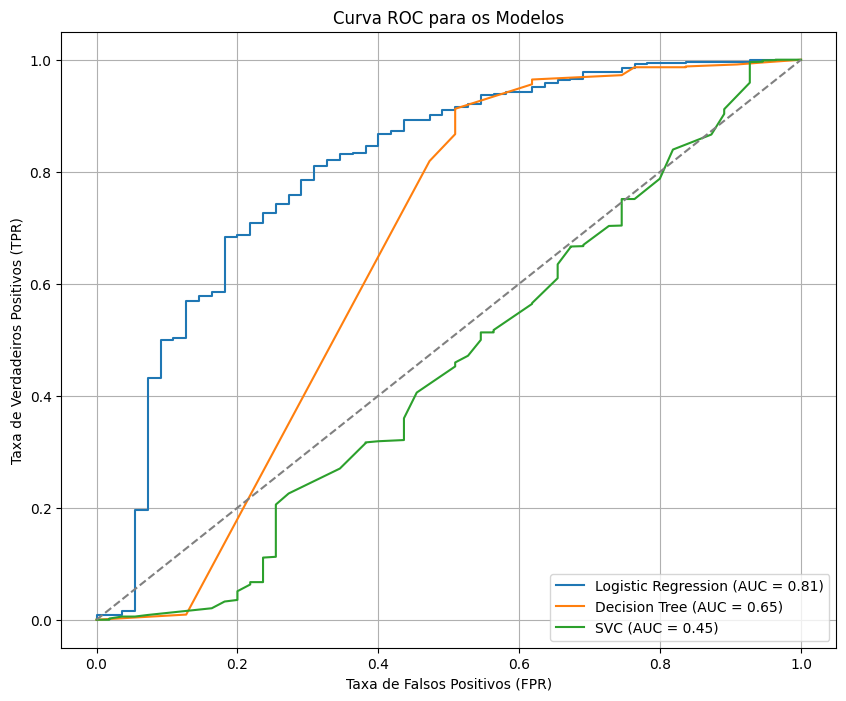

In [ ]:
# Função para calcular a curva ROC e AUC
def plot_roc_curve(model, x_train, x_test, y_train, y_test, label):
    # Previsões de probabilidade para a classe positiva (1)
    y_prob = model.predict_proba(x_test)[:, 1]

    # Calculando a curva ROC e AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    # Plotando a curva ROC
    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc:.2f})')

# Logistic Regression
best_logistic_regression = random_search_logistic_regression.best_estimator_
best_logistic_regression.fit(x_train, y_train)

# Decision Tree
best_decision_tree = random_search_decision_three.best_estimator_
best_decision_tree.fit(x_train, y_train)

# SVC
best_svc = random_search_svm.best_estimator_
best_svc.fit(x_train, y_train)

# Plotando a curva ROC para cada modelo
plt.figure(figsize=(10, 8))
plot_roc_curve(best_logistic_regression, x_train, x_test, y_train, y_test, 'Logistic Regression')
plot_roc_curve(best_decision_tree, x_train, x_test, y_train, y_test, 'Decision Tree')
plot_roc_curve(best_svc, x_train, x_test, y_train, y_test, 'SVC')

# Curva ROC do classificador aleatório (linha diagonal)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Títulos e rótulos
plt.title('Curva ROC para os Modelos')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### 10. Escolha do modelo



Com base nos resultados obtidos, tanto a Regressão Logística quanto a Árvore de Decisão apresentaram desempenho semelhante em termos de acurácia (96%) e métricas como precisão, recall e F1-score para a classe majoritária (1). No entanto, ambos os modelos tiveram um desempenho muito ruim na classe minoritária (0), com precision e recall zerados, o que indica uma grande dificuldade em classificar corretamente essa classe.

Ao analisar a métrica AUC, que mede a capacidade do modelo de distinguir entre as classes, a Regressão Logística apresentou o melhor valor (0.75), seguida pela Árvore de Decisão (0.70) e pelo SVC (0.63). Como um AUC maior indica um modelo com melhor separabilidade entre as classes, a Regressão Logística se destaca como a melhor escolha dentre os modelos avaliados.

Dessa forma, considerando todas as métricas analisadas, a **Regressão Logística** é a melhor opção para essa tarefa, pois apresenta um bom equilíbrio entre desempenho geral e capacidade de discriminação entre as classes.

### 10. Usando dados de vinho tinto no modelo

Vamos agora usar os dados de vinho tinto, presentes na base orignial e fazer inferencia sem treinar novamente conforme o requisito da tarefa, para podermos saber se os vinhos sao bons ou ruins.

In [70]:
# filtra os dados de vinho tinto
df_red_wine = df[df['type'] == 'red']

# cria a variavel 'opinion' para os vinhos tintos
df_red_wine['opinion'] = (df_red_wine['quality'] >= 5).astype(int)

# separa as features e o target
x_red = df_red_wine.drop([target, 'quality'], axis=1)
y_red = df_red_wine[[target]]

# Define os modelos a serem avaliados
models = {
    'logistic_regression': random_search_logistic_regression.best_estimator_,
    'decision_three': random_search_decision_three.best_estimator_,
    'svc': random_search_svm.best_estimator_
}

# Valores da base de teste dos vinhos brancos
white_metrics = {
    'logistic_regression': {'accuracy': 0.96, 'precision': 0.96, 'recall': 1.00, 'f1': 0.98},
    'decision_three': {'accuracy': 0.96, 'precision': 0.97, 'recall': 0.99, 'f1': 0.98},
    'svc': {'accuracy': 0.96, 'precision': 0.96, 'recall': 1.00, 'f1': 0.98}
}

for model_name, model in models.items():
  # realiza a inferencia
  predicted_red = model.predict(x_red)

  # calcula a quantidade de vinhos bons e ruins
  good_red_wines = np.sum(predicted_red == 1)
  bad_red_wines = np.sum(predicted_red == 0)

  # printa a quantidade de vinhos bons e ruins
  print(f'{model_name}:')
  print(f'Quantidade de vinhos bons: {good_red_wines}')
  print(f'Quantidade de vinhos ruins: {bad_red_wines}')

  # avalia o desempenho do modelo nos dados de vinho tinto
  print(f'\nDesempenho do modelo {model_name} dos dados de vinho tinto:')
  print(classification_report(y_red, predicted_red))

  # compara o desempenho com os dados de vinho branco
  print(f'Comparando o resultado vinho tinto e vinho branco para o modelo {model_name}:')

  report_dict = classification_report(y_red, predicted_red, output_dict=True)
  for metric in ['accuracy', 'precision', 'recall', 'f1']:

      valor_branco = white_metrics[model_name][metric]
      # Calcula a diferença entre as métricas (tinto - branco)
      try:
        diferenca = report_dict['1'][metric] - valor_branco
      except KeyError:
        diferenca = 0 - valor_branco
      # Formata a diferença com 2 casas decimais
      print(f'{metric.capitalize()}: diferença = {diferenca:.2f}')

logistic_regression:
Quantidade de vinhos bons: 1375
Quantidade de vinhos ruins: 224

Desempenho do modelo logistic_regression dos dados de vinho tinto:
              precision    recall  f1-score   support

           0       0.14      0.49      0.22        63
           1       0.98      0.87      0.92      1536

    accuracy                           0.86      1599
   macro avg       0.56      0.68      0.57      1599
weighted avg       0.94      0.86      0.89      1599

Comparando o resultado vinho tinto e vinho branco para o modelo logistic_regression:
Accuracy: diferença = -0.96
Precision: diferença = 0.02
Recall: diferença = -0.13
F1: diferença = -0.98
decision_three:
Quantidade de vinhos bons: 1017
Quantidade de vinhos ruins: 582

Desempenho do modelo decision_three dos dados de vinho tinto:
              precision    recall  f1-score   support

           0       0.08      0.73      0.14        63
           1       0.98      0.65      0.78      1536

    accuracy            

<ipython-input-70-665735021b26>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_red_wine['opinion'] = (df_red_wine['quality'] >= 5).astype(int)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown

Como podemos ver o resultado acima, o modelo não desempenhou tão bem com a nova base.

Analisando os resultados da inferência nos vinhos tintos:
- O modelo Logistic Regression teve um recall muito baixo para a classe 0 (vinhos ruins), o que indica que ele não consegue identificar bem essa classe.
- O Decision Tree teve um desempenho intermediário, mas com baixa precisão para vinhos ruins.
- O SVC praticamente classificou todos os vinhos como bons (classe 1), ignorando a existência de vinhos ruins.

Isso indica que os modelos podem ter sido enviesados pela distribuição da base de treinamento (provavelmente com um número maior de vinhos bons), resultando em um desempenho pior na nova base.